In [164]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import savgol_filter, find_peaks

In [101]:
def gompertz(t, A, mu, l):
    log_B = A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))
    return log_B

In [185]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
positions = pd.read_excel('../Positions.xlsx')

df = pd.read_excel('../data_processed.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')

grouped_df = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
grouped_df.rename(columns={'colonies': 'total_colonies'}, inplace=True)
"""
agg_colony_area_df = df.groupby(['Date', 'Machine', 'Pad'])['area_max_um'].agg(['mean', 'std']).reset_index()
agg_colony_area_df.rename(columns={'mean': 'mean_colony_area', 'std': 'std_colony_area'}, inplace=True)

merged_df = pd.merge(grouped_df, agg_colony_area_df, on=['Date', 'Machine', 'Pad'], how='inner')
merged_df
"""
# Group by 'Date', 'Machine', and 'Pad' and calculate mean, std, and count of 'area_max_um'
agg_colony_area_df = df.groupby(['Date', 'Machine', 'Pad'])['area_max_um'].agg(['mean', 'std', 'count']).reset_index()

# Rename the columns for clarity
agg_colony_area_df.rename(columns={'mean': 'mean_colony_area', 'std': 'std_colony_area', 'count': 'num_colonies'}, inplace=True)

# Merge the grouped data from 'positions' and the aggregated colony area data from 'df'
merged_df = pd.merge(grouped_df, agg_colony_area_df, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
merged_df.head()

Date      Machine  Pad  total_colonies  mean_colony_area  \
0 2023-11-15     Ti scope    1            19.0     127494.473143   
1 2023-11-15     Ti scope    2            23.0      46725.168600   
2 2023-11-15  Tweez scope    1             3.0     768482.640000   
3 2023-11-15  Tweez scope    2             1.0     476031.532500   
4 2023-11-17     Ti scope    1             6.0     366810.583800   

   std_colony_area  num_colonies  
0     21643.298316             7  
1     15593.763903             2  
2     99168.204670             2  
3              NaN             1  
4     47734.937249             6

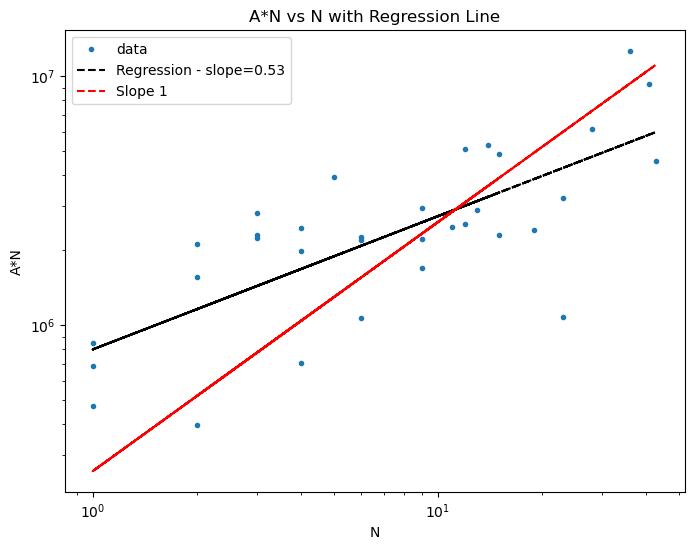

In [186]:
AN = merged_df['total_colonies'] * merged_df['mean_colony_area']

# linear regression in log-log space
log_N = np.log10(merged_df['total_colonies'])
log_AN = np.log10(AN)

# fit the regression model (linear fit in log-log space)
slope, intercept = np.polyfit(log_N, log_AN, 1)
# create the regression line in log-log space
regression_line = 10**(slope * log_N + intercept)

# Calculate the scaling factor to align the slope 1 line with the data
scaling_factor = (merged_df['total_colonies'] * merged_df['mean_colony_area']).mean() / merged_df['total_colonies'].mean()
# Plotting a slope 1 line for reference in log-log space, scaled to match the data
slope_1_line = scaling_factor * merged_df['total_colonies']  # Slope 1 line

plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')

plt.plot(merged_df['total_colonies'], AN, '.', label='data')
plt.plot(merged_df['total_colonies'], regression_line, '--', label=f'Regression - slope={slope:.2f}', color='black')
plt.plot(merged_df['total_colonies'], slope_1_line, '--', label='Slope 1', color='red')

plt.ylabel('A*N')
plt.xlabel('N')
plt.title('A*N vs N with Regression Line')

plt.legend()

plt.show()

##### Time lag

In [88]:
df.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'exp length', 'Quality', 'colonies',
       'center_colony', 'radius_mask', 'radj_mask', 'incub_time', 'um_px',
       'vel_start', 'vel_stop', 'vel_fit_start', 'vel_fit_end',
       'time_wave_start', 'time_wave_arrival', 'degree', 'Delta used',
       'area_max_px', 'radius_px', 'area_px', 'r0', 'wave_pos_coefs',
       'wave_speed_av', 'rad_max_px', 'area_max_um', 'rad_max_um',
       'gompertz_params_um', 'logistic_params_um', 'gomp_params_px',
       'gompertz_params_px', 'logistic_params_px', 't_m_gomp_px',
       't_m_gomp_um', 't_m_logistic_px', 't_m_logistic_um', 'r0_um',
       'exp_gompertz_params_um', 'exp_logistic_params_um', 'exp_A_gompertz_um',
       'exp_mu_gompertz_um', 'exp_l_gompertz_um'],
      dtype='object')

In [187]:
gomp_params_um = np.zeros((160,3))
for i in df.index.values:
    gomp_um = json.loads(df.loc[i,'exp_gompertz_params_um'])
    gomp_params_um[i,0] = gomp_um['A']
    gomp_params_um[i,1] = gomp_um['mu_m']
    gomp_params_um[i,2] = gomp_um['lambda']

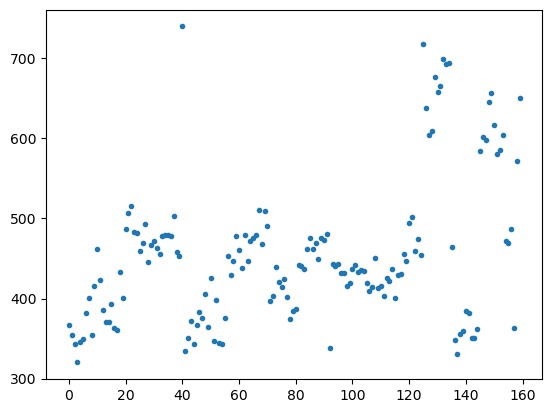

In [188]:
plt.plot(gomp_params_um[:,2], '.')

In [195]:
df_aux = df.copy()

In [196]:
df_aux['A_gomp_mu'] = gomp_params_um[:,0]
df_aux['mu_gomp_mu'] = gomp_params_um[:,1]
df_aux['l_gomp_mu'] = gomp_params_um[:,2]

In [197]:
#df_l = df_aux[df_aux.l_gomp_mu > 0]

In [198]:
df_grouped = df_aux.groupby(['Date','Machine','Pad'])[['A_gomp_mu','mu_gomp_mu','l_gomp_mu']].agg(['mean','std']).reset_index()
df_grouped.columns = ['_'.join(filter(None, col)).strip('_') for col in df_grouped.columns.values]
df_grouped

Date      Machine  Pad  A_gomp_mu_mean  A_gomp_mu_std  \
0  2023-11-15     Ti scope    1    1.248445e+05   21029.801508   
1  2023-11-15     Ti scope    2    4.495194e+04   14489.775087   
2  2023-11-15  Tweez scope    1    7.617765e+05   97483.118508   
3  2023-11-15  Tweez scope    2    4.698811e+05            NaN   
4  2023-11-17     Ti scope    1    3.628912e+05   47016.657223   
5  2023-11-17  Tweez scope    1    9.474684e+05            NaN   
6  2023-11-17  Tweez scope    2    6.795439e+05            NaN   
7  2023-11-28     Ti scope    1    7.807279e+05            NaN   
8  2023-11-28     Ti scope    2    1.059438e+06   63619.331429   
9  2023-11-28  Tweez scope    1    3.738653e+05  137546.017854   
10 2023-11-30     Ti scope    1    7.794568e+05  180676.323064   
11 2023-11-30     Ti scope    3    7.435853e+05            NaN   
12 2023-11-30     Ti scope    4    6.052933e+05  162507.326823   
13 2023-11-30     Ti scope    5    8.358024e+05            NaN   
14 2023-11-30  Tweez scope    2    1.031942e+05   34201.507239   
15 2023-11-30  Tweez scope    3    1.389769e+05            NaN   
16 2023-12-04     Ti scope    1    3.441656e+05   68483.417086   
17 2023-12-04  Tweez scope    1    2.239134e+05   75654.100104   
18 2023-12-04  Tweez scope    2    2.122820e+05   44994.262116   
19 2023-12-06  Tweez scope    1    4.197640e+05   94548.334336   
20 2023-12-06  Tweez scope    3    2.188560e+05   64269.043177   
21 2023-12-06  Tweez scope    4    2.427139e+05   78760.321366   
22 2023-12-08     Ti scope    1    2.204384e+05   31655.802596   
23 2023-12-08     Ti scope    2    3.216104e+05   45022.869158   
24 2023-12-08     Ti scope    3    1.732236e+05   44451.859955   
25 2023-12-08     Ti scope    4    3.736015e+05   71525.261861   
26 2023-12-08     Ti scope    5    4.928813e+05   94469.859998   
27 2023-12-08  Tweez scope    1    1.927949e+05   12793.066769   
28 2023-12-08  Tweez scope    2    2.105374e+05   19270.396601   
29 2023-12-08  Tweez scope    3    3.214412e+05   72403.544737   
30 2023-12-08  Tweez scope    5    1.500969e+05   83583.526156   
31 2023-12-08  Tweez scope    6    1.853281e+05   27936.465809   
32 2023-12-08  Tweez scope    7    1.742119e+05   19975.742559   

    mu_gomp_mu_mean  mu_gomp_mu_std  l_gomp_mu_mean  l_gomp_mu_std  
0        414.191583       76.516720      347.800244      14.380985  
1        115.569613       45.912775      390.868546      13.372971  
2       1649.906804       39.333283      438.492732      32.238057  
3       1050.361417             NaN      423.652957            NaN  
4        801.770218      124.341067      373.917668      12.847202  
5        972.765650             NaN      433.538176            NaN  
6       1503.784487             NaN      401.160040            NaN  
7       1272.462729             NaN      487.450080            NaN  
8       1274.247445       77.737540      511.483052       6.531330  
9        800.308866      316.208145      469.812077      13.650785  
10      1503.824879      413.422190      478.995694       0.091254  
11      1783.352986             NaN      478.474550            NaN  
12      1083.243622      294.709448      471.439114      27.781964  
13      1136.868405             NaN      739.931809            NaN  
14       255.743128      105.867796      364.540471      21.685959  
15       484.300951             NaN      425.180566            NaN  
16       762.655732      217.110894      469.016061      23.856640  
17       624.524502      245.876882      398.806526      27.753808  
18       631.110365      157.280228      456.738112      16.083953  
19       815.816452      221.193205      427.172195       9.399104  
20       613.937838      217.597377      424.953480      14.523673  
21      1142.198869      505.018109      421.801456      16.385197  
22       673.861941       94.697381      453.645147      24.524220  
23       842.348100      143.333266      472.721882      21.355828  
24       359.500505       97.401222    

In [199]:
# Merge the grouped data from 'positions' and the aggregated colony area data from 'df'
merged_gomp = pd.merge(df_grouped, merged_df, on=['Date', 'Machine', 'Pad'], how='inner')

# Display the merged dataframe
merged_gomp

Date      Machine  Pad  A_gomp_mu_mean  A_gomp_mu_std  \
0  2023-11-15     Ti scope    1    1.248445e+05   21029.801508   
1  2023-11-15     Ti scope    2    4.495194e+04   14489.775087   
2  2023-11-15  Tweez scope    1    7.617765e+05   97483.118508   
3  2023-11-15  Tweez scope    2    4.698811e+05            NaN   
4  2023-11-17     Ti scope    1    3.628912e+05   47016.657223   
5  2023-11-17  Tweez scope    1    9.474684e+05            NaN   
6  2023-11-17  Tweez scope    2    6.795439e+05            NaN   
7  2023-11-28     Ti scope    1    7.807279e+05            NaN   
8  2023-11-28     Ti scope    2    1.059438e+06   63619.331429   
9  2023-11-28  Tweez scope    1    3.738653e+05  137546.017854   
10 2023-11-30     Ti scope    1    7.794568e+05  180676.323064   
11 2023-11-30     Ti scope    3    7.435853e+05            NaN   
12 2023-11-30     Ti scope    4    6.052933e+05  162507.326823   
13 2023-11-30     Ti scope    5    8.358024e+05            NaN   
14 2023-11-30  Tweez scope    2    1.031942e+05   34201.507239   
15 2023-11-30  Tweez scope    3    1.389769e+05            NaN   
16 2023-12-04     Ti scope    1    3.441656e+05   68483.417086   
17 2023-12-04  Tweez scope    1    2.239134e+05   75654.100104   
18 2023-12-04  Tweez scope    2    2.122820e+05   44994.262116   
19 2023-12-06  Tweez scope    1    4.197640e+05   94548.334336   
20 2023-12-06  Tweez scope    3    2.188560e+05   64269.043177   
21 2023-12-06  Tweez scope    4    2.427139e+05   78760.321366   
22 2023-12-08     Ti scope    1    2.204384e+05   31655.802596   
23 2023-12-08     Ti scope    2    3.216104e+05   45022.869158   
24 2023-12-08     Ti scope    3    1.732236e+05   44451.859955   
25 2023-12-08     Ti scope    4    3.736015e+05   71525.261861   
26 2023-12-08     Ti scope    5    4.928813e+05   94469.859998   
27 2023-12-08  Tweez scope    1    1.927949e+05   12793.066769   
28 2023-12-08  Tweez scope    2    2.105374e+05   19270.396601   
29 2023-12-08  Tweez scope    3    3.214412e+05   72403.544737   
30 2023-12-08  Tweez scope    5    1.500969e+05   83583.526156   
31 2023-12-08  Tweez scope    6    1.853281e+05   27936.465809   
32 2023-12-08  Tweez scope    7    1.742119e+05   19975.742559   

    mu_gomp_mu_mean  mu_gomp_mu_std  l_gomp_mu_mean  l_gomp_mu_std  \
0        414.191583       76.516720      347.800244      14.380985   
1        115.569613       45.912775      390.868546      13.372971   
2       1649.906804       39.333283      438.492732      32.238057   
3       1050.361417             NaN      423.652957            NaN   
4        801.770218      124.341067      373.917668      12.847202   
5        972.765650             NaN      433.538176            NaN   
6       1503.784487             NaN      401.160040            NaN   
7       1272.462729             NaN      487.450080            NaN   
8       1274.247445       77.737540      511.483052       6.531330   
9        800.308866      316.208145      469.812077      13.650785   
10      1503.824879      413.422190      478.995694       0.091254   
11      1783.352986             NaN      478.474550            NaN   
12      1083.243622      294.709448      471.439114      27.781964   
13      1136.868405             NaN      739.931809            NaN   
14       255.743128      105.867796      364.540471      21.685959   
15       484.300951             NaN      425.180566            NaN   
16       762.655732      217.110894      469.016061      23.856640   
17       624.524502      245.876882      398.806526      27.753808   
18       631.110365      157.280228      456.738112      16.083953   
19       815.816452      221.193205      427.172195       9.399104   
20       613.937838      217.597377      424.953480      14.523673   
21      1142.198869      505.018109      421.801456      16.385197   
22       673.861941       94.697381      453.645147      24.524220   
23       842.348100      143.333266      472.721882      21.355828   
24       359.5

In [200]:
grouped_df = positions.groupby(['Date', 'Machine', 'Pad'])['colonies'].sum().reset_index()
grouped_df.rename(columns={'colonies': 'total_colonies'}, inplace=True)

# Merge the grouped data back into the original DataFrame
positions_with_totals = df.merge(grouped_df, on=['Date', 'Machine', 'Pad'], how='left')

# Display the updated DataFrame
positions_with_totals

Date      Machine  Position  Strain            DNA Chemical  Pad  \
0   2023-11-15     Ti scope         0  MC4100  pLPT20&pLPT41        -    1   
1   2023-11-15     Ti scope         1  MC4100  pLPT20&pLPT41        -    1   
2   2023-11-15     Ti scope         3  MC4100  pLPT20&pLPT41        -    1   
3   2023-11-15     Ti scope         6  MC4100  pLPT20&pLPT41        -    1   
4   2023-11-15     Ti scope         7  MC4100  pLPT20&pLPT41        -    1   
..         ...          ...       ...     ...            ...      ...  ...   
155 2023-12-08  Tweez scope        34  MC4100  pLPT20&pLPT41     ATC+    7   
156 2023-12-08  Tweez scope        35  MC4100  pLPT20&pLPT41     ATC+    7   
157 2023-12-08  Tweez scope        36  MC4100  pLPT20&pLPT41     ATC-    2   
158 2023-12-08  Tweez scope        37  MC4100  pLPT20&pLPT41     ATC+    5   
159 2023-12-08  Tweez scope        38  MC4100  pLPT20&pLPT41     ATC+    5   

    Dilution   t_incub      t_im  ...  t_m_logistic_px t_m_logistic_um  \
0    10^(-5)  09:25:00  14:41:00  ...       225.219582      222.192596   
1    10^(-5)  09:25:00  14:41:00  ...       216.254727      214.616296   
2    10^(-5)  09:25:00  14:41:00  ...       209.428395      207.882467   
3    10^(-5)  09:25:00  14:41:00  ...       199.904423      198.436991   
4    10^(-5)  09:25:00  14:41:00  ...       211.573719      208.804174   
..       ...       ...       ...  ...              ...             ...   
155  10^(-5)  14:18:00  19:07:00  ...       276.011331      269.045952   
156  10^(-5)  14:18:00  19:07:00  ...       288.330820      280.881501   
157  10^(-5)  14:18:00  19:07:00  ...       220.637591      216.400798   
158  10^(-5)  14:18:00  19:07:00  ...       340.232716      330.117102   
159  10^(-5)  14:18:00  19:07:00  ...       333.014969      318.734681   

         r0_um                             exp_gompertz_params_um  \
0    25.726989  {"A": 103786.40805606885, "mu_m": 343.23542055...   
1    37.567485  {"A": 148648.89711510084, "mu_m": 486.68795192...   
2    50.002925  {"A": 138470.38679296238, "mu_m": 463.74374579...   
3    23.368757  {"A": 100919.60666645512, "mu_m": 319.21784622...   
4    35.216651  {"A": 131433.34432578104, "mu_m": 451.35653828...   
..         ...                                                ...   
155  37.981230  {"A": 177118.2350419084, "mu_m": 428.262304181...   
156  38.860754  {"A": 192575.21657518644, "mu_m": 440.12486370...   
157  46.818870  {"A": 213726.85891700353, "mu_m": 643.58659898...   
158  66.262243  {"A": 192085.07434235833, "mu_m": 376.09818454...   
159   0.000540  {"A": 43715.03939930838, "mu_m": 82.8453568962...   

                                exp_logistic_params_um  exp_A_gompertz_um  \
0    {"A": 103366.57837067322, "mu_m": 332.93634006...      103786.408056   
1    {"A": 148057.68875721024, "mu_m": 469.79915164...      148648.897115   
2    {"A": 137951.62607133528, "mu_m": 444.93982071...      138470.386793   
3    {"A": 100554.69020091348, "mu_m": 301.18127957...      100919.606666   
4    {"A": 130968.07500264472, "mu_m": 432.72130505...      131433.344326   
..                                                 ...                ...   
155  {"A": 176619.87026755814, "mu_m": 418.55945024...      177118.235042   
156  {"A": 191981.51294624986, "mu_m": 429.55772715...      192575.216575   
157  {"A": 213302.05579130517, "mu_m": 622.84842423...      213726.858917   
158  {"A": 191289.16087412895, "mu_m": 370.83220448...      192085.074342   
159  {"A": 43574.11118276127, "mu_m": 78.8367628981...       43715.039399   

     exp_mu_gompertz_um  exp_l_gompertz_um  exp_gomp_growth_stops_10  \
0            343.235421         366.413048                       982   
1            486.687952         354.501293                      1015   
2            463.743746         343.273677                       984   
3            319.217846         320.089559                       955   
4            451.356538         345.419715                       968  

Text(0.5, 0, 'N')

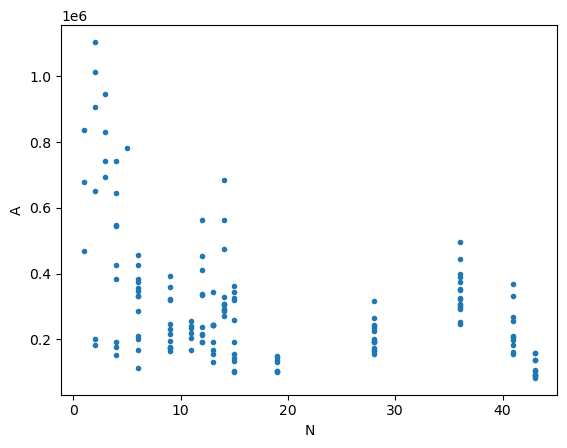

In [217]:
#plt.yscale('log')
plt.plot(positions_with_totals['total_colonies'],positions_with_totals['exp_A_gompertz_um'],'.')
plt.ylabel('A')
plt.xlabel('N')

Text(0.5, 0, 'N')

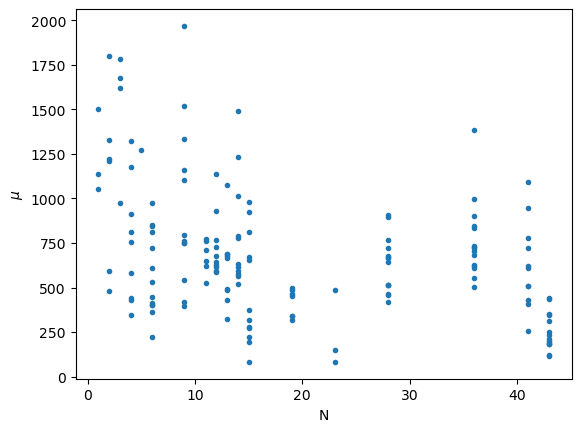

In [202]:
plt.plot(positions_with_totals['total_colonies'],positions_with_totals['exp_mu_gompertz_um'],'.')
plt.ylabel('$\mu$')
plt.xlabel('N')

Text(0.5, 0, 'N')

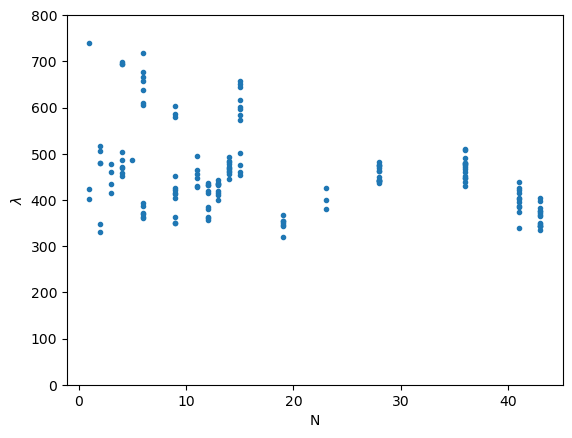

In [203]:
plt.plot(positions_with_totals['total_colonies'],positions_with_totals['exp_l_gompertz_um'],'.')
plt.ylabel('$\lambda$')
plt.ylim([0,800])
plt.xlabel('N')

Text(0.5, 0, 'N')

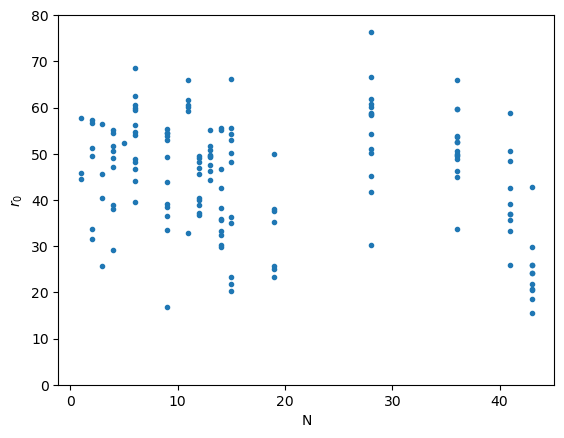

In [204]:
positions_with_totals = positions_with_totals[positions_with_totals.r0_um>1]
plt.plot(positions_with_totals['total_colonies'],positions_with_totals['r0_um'],'.')
plt.ylabel('$r_0$')
plt.ylim([0,80])
plt.xlabel('N')

Text(0, 0.5, 'A')

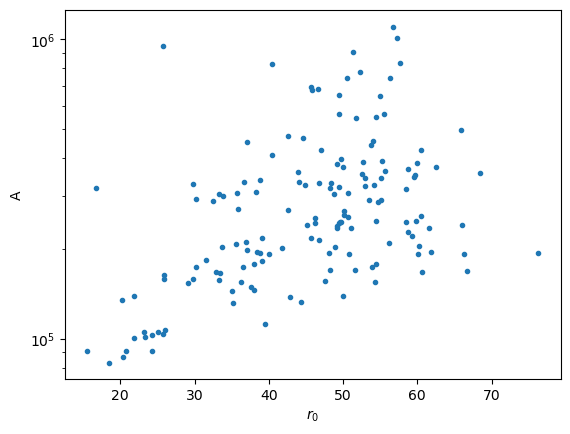

In [220]:
## more restrictions, it's costly
plt.yscale('log')
positions_with_totals = positions_with_totals[positions_with_totals.r0_um>1]
plt.plot(positions_with_totals['r0_um'],positions_with_totals['exp_A_gompertz_um'],'.')
plt.xlabel('$r_0$')
#plt.ylim([0,80])
plt.ylabel('A')

#### Time stops growth

0


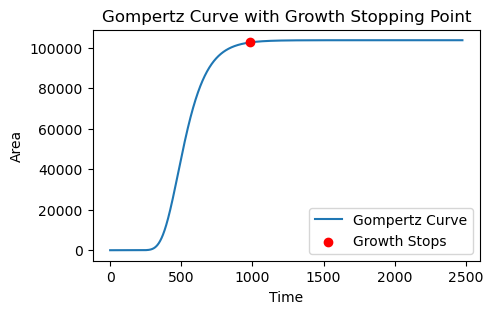

The colony stops growing around time: 982
1


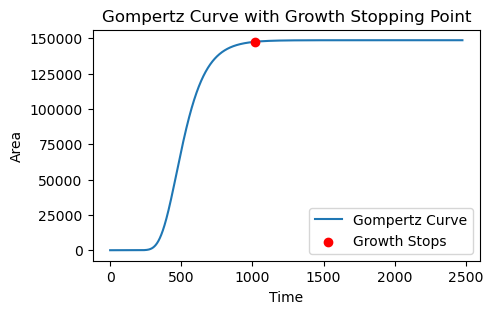

The colony stops growing around time: 1015
2


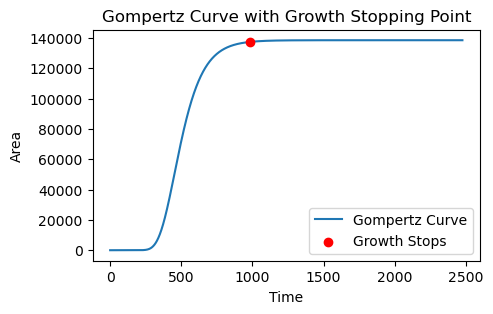

The colony stops growing around time: 984
3


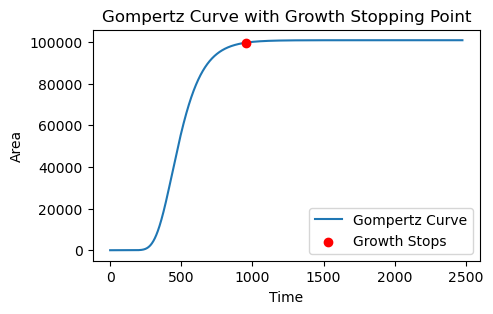

The colony stops growing around time: 955
4


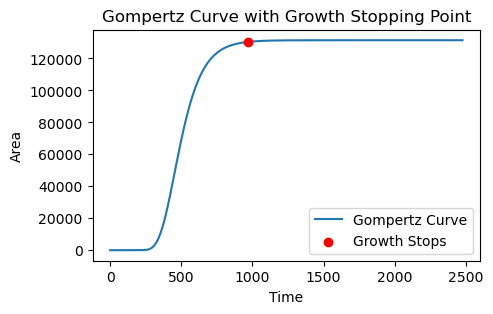

The colony stops growing around time: 968
5


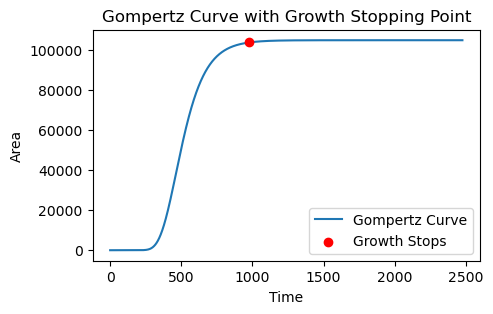

The colony stops growing around time: 976
6


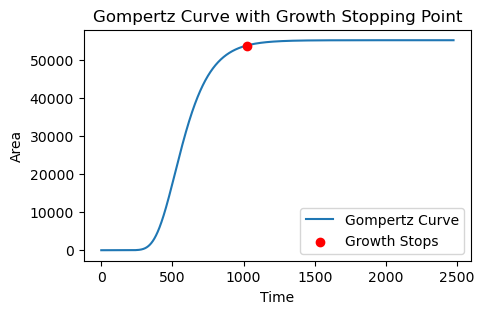

The colony stops growing around time: 1022
7


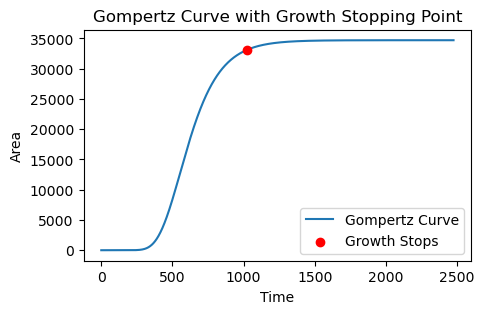

The colony stops growing around time: 1026
8


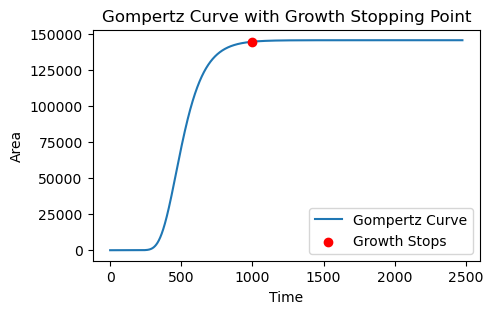

The colony stops growing around time: 995
9


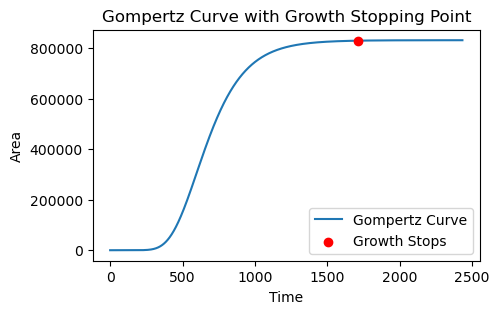

The colony stops growing around time: 1713
10


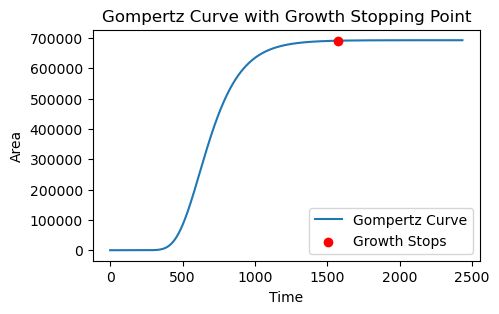

The colony stops growing around time: 1575
11


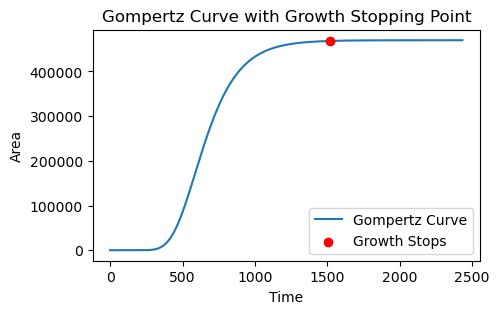

The colony stops growing around time: 1519
12


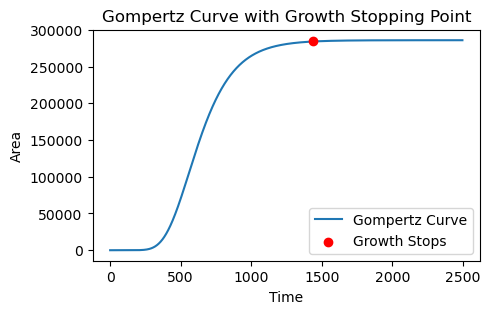

The colony stops growing around time: 1440
13


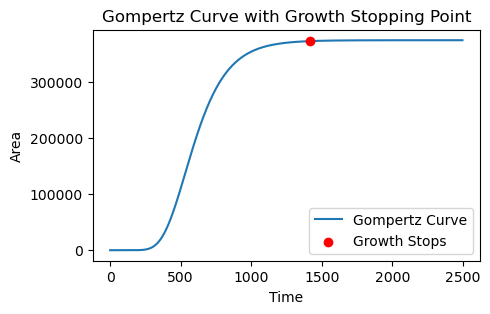

The colony stops growing around time: 1415
14


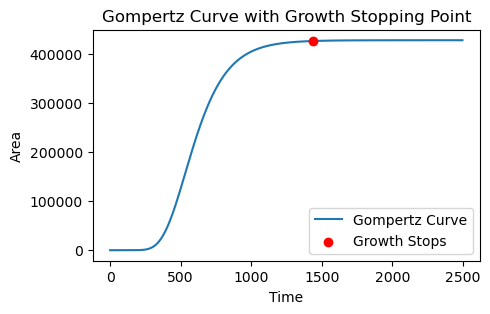

The colony stops growing around time: 1434
15


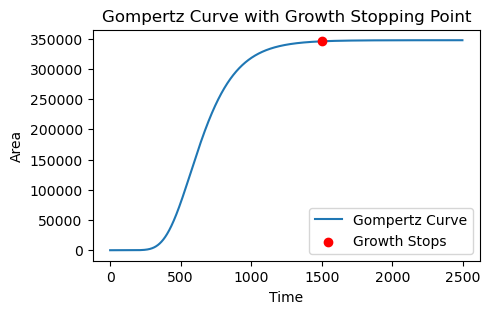

The colony stops growing around time: 1504
16


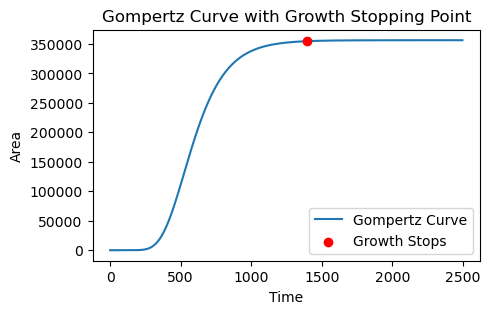

The colony stops growing around time: 1397
17


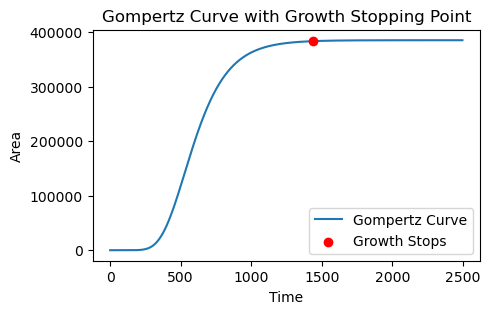

The colony stops growing around time: 1440
18


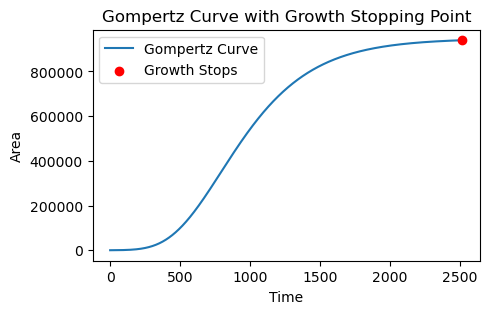

The colony stops growing around time: 2519
19


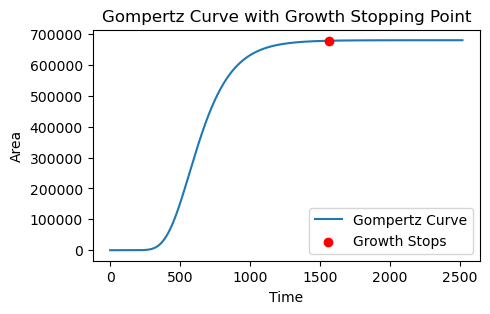

The colony stops growing around time: 1567
20


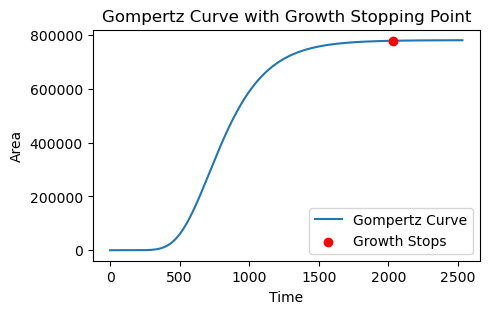

The colony stops growing around time: 2033
21


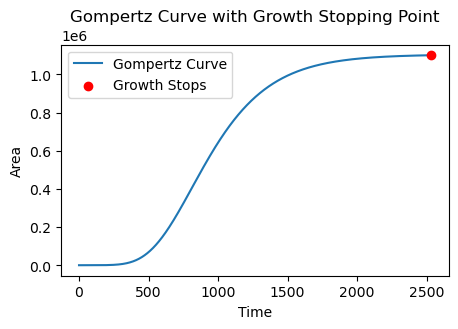

The colony stops growing around time: 2533
22


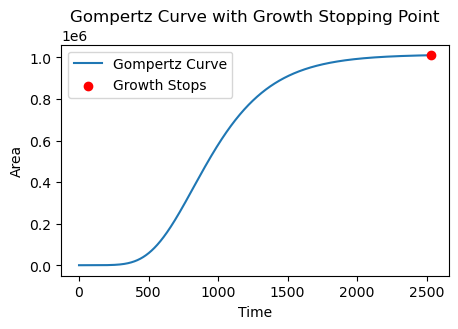

The colony stops growing around time: 2533
23


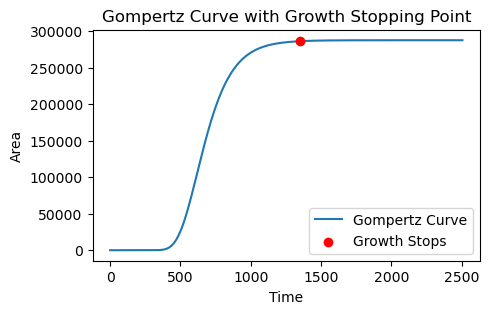

The colony stops growing around time: 1348
24


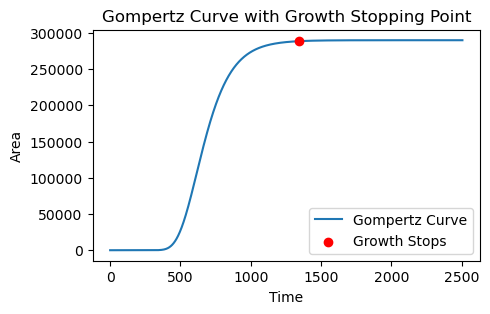

The colony stops growing around time: 1340
25


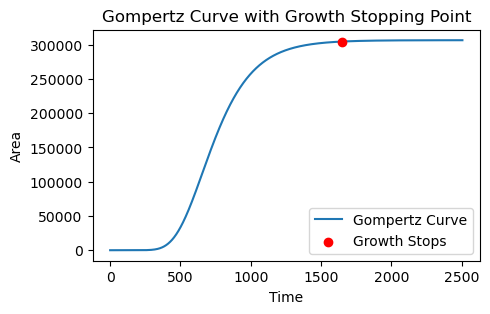

The colony stops growing around time: 1648
26


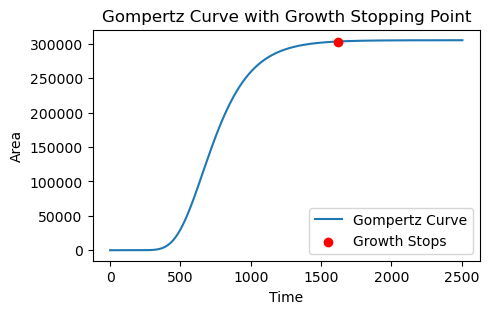

The colony stops growing around time: 1618
27


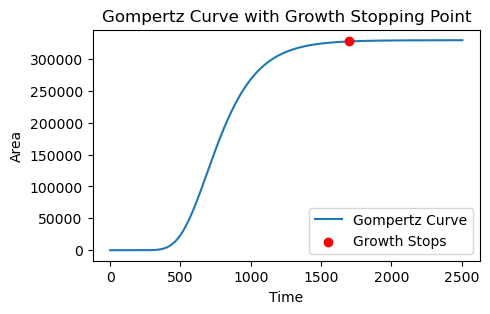

The colony stops growing around time: 1696
28


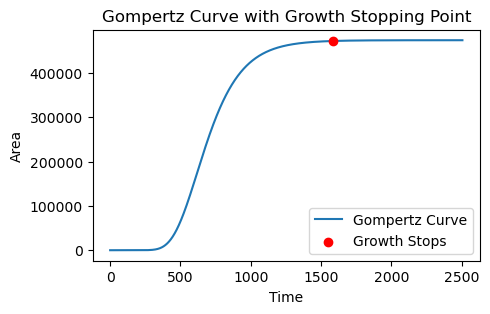

The colony stops growing around time: 1586
29


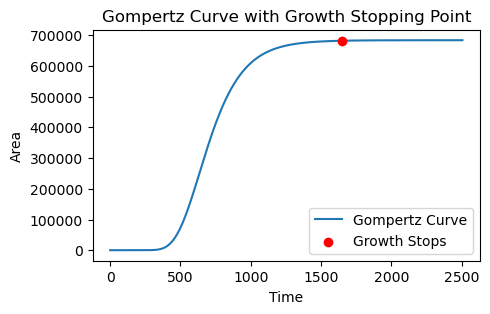

The colony stops growing around time: 1648
30


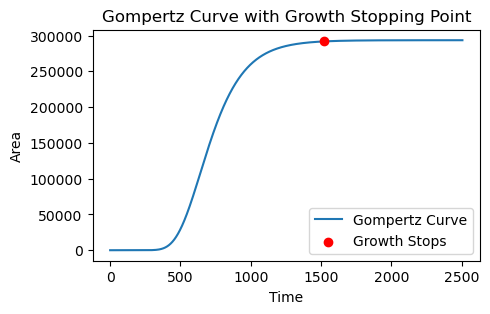

The colony stops growing around time: 1518
31


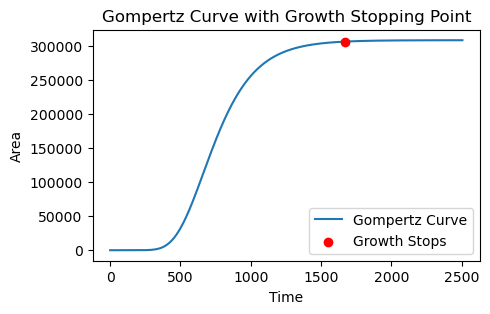

The colony stops growing around time: 1673
32


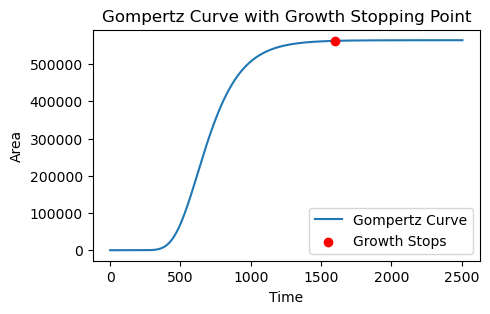

The colony stops growing around time: 1603
33


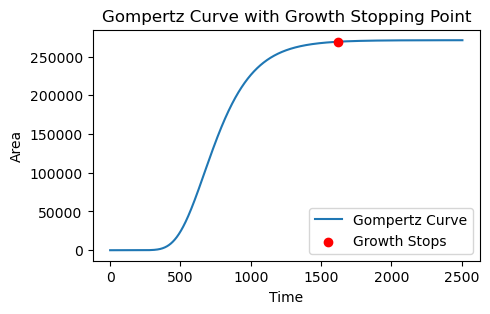

The colony stops growing around time: 1624
34


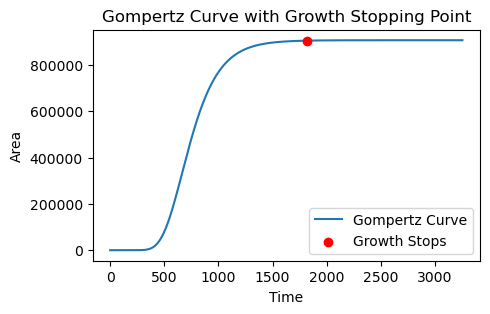

The colony stops growing around time: 1815
35


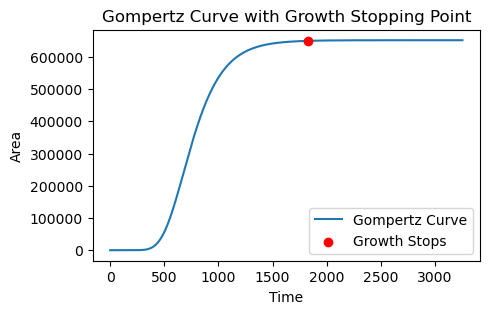

The colony stops growing around time: 1824
36


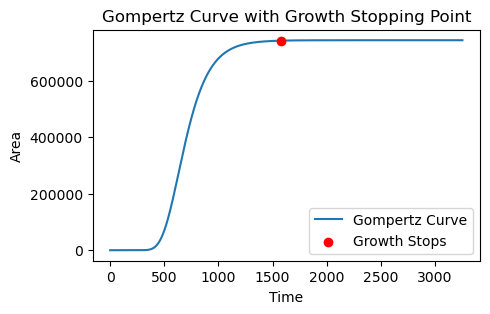

The colony stops growing around time: 1581
37


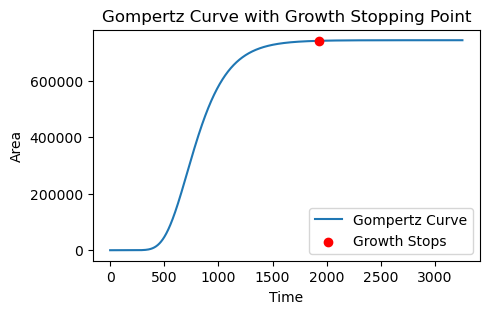

The colony stops growing around time: 1929
38


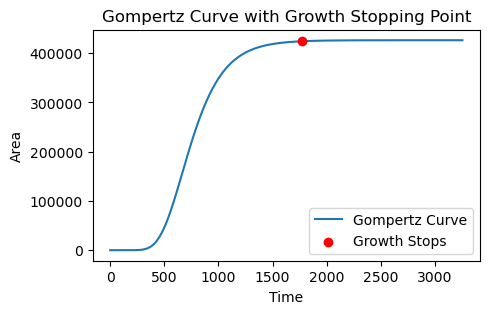

The colony stops growing around time: 1773
39


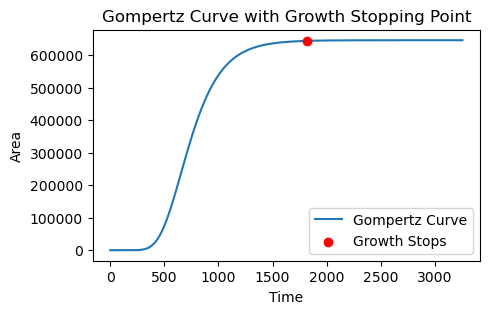

The colony stops growing around time: 1821
40


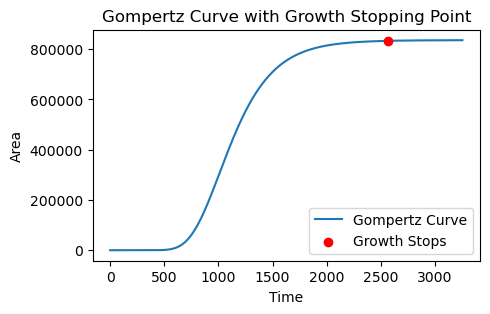

The colony stops growing around time: 2561
41


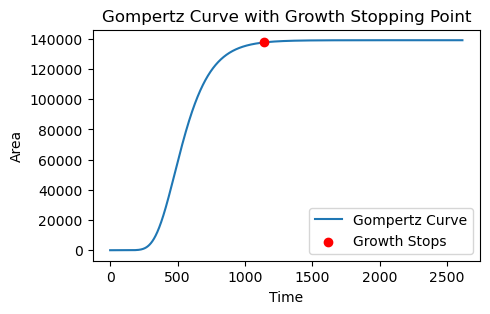

The colony stops growing around time: 1143
42


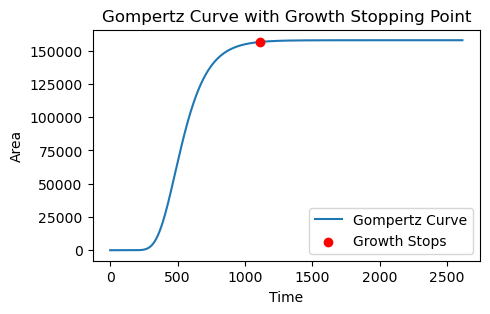

The colony stops growing around time: 1111
43


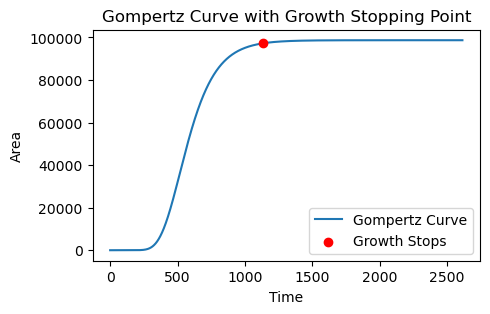

The colony stops growing around time: 1133
44


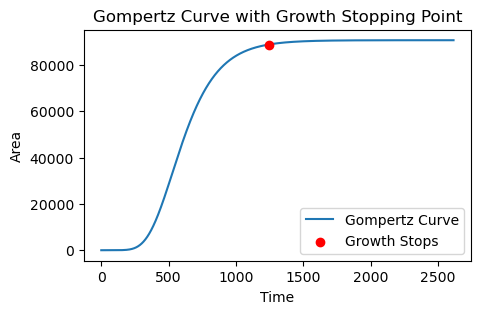

The colony stops growing around time: 1243
45


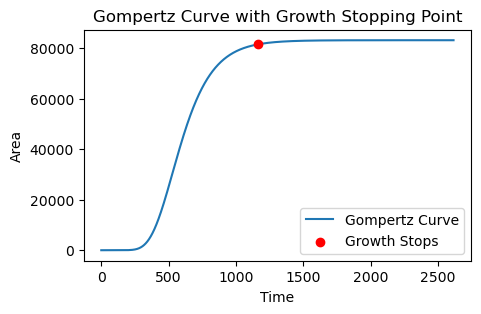

The colony stops growing around time: 1164
46


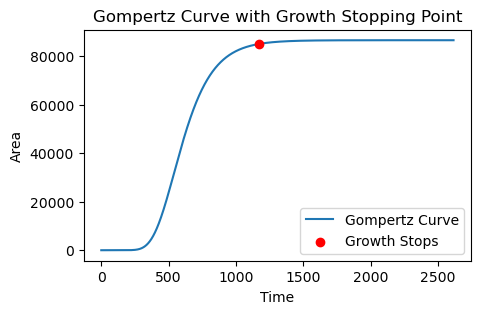

The colony stops growing around time: 1167
47


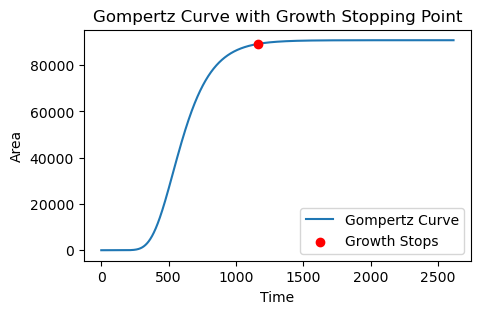

The colony stops growing around time: 1165
48


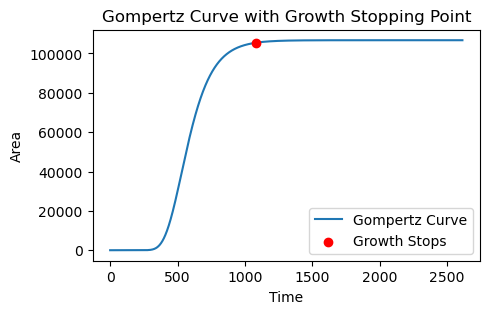

The colony stops growing around time: 1084
49


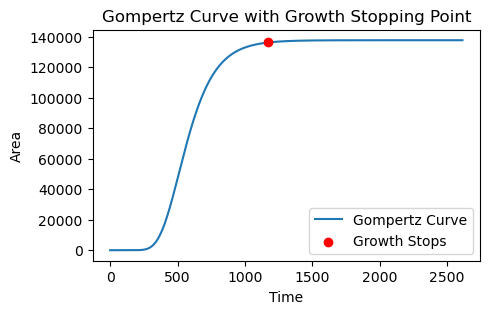

The colony stops growing around time: 1175
50


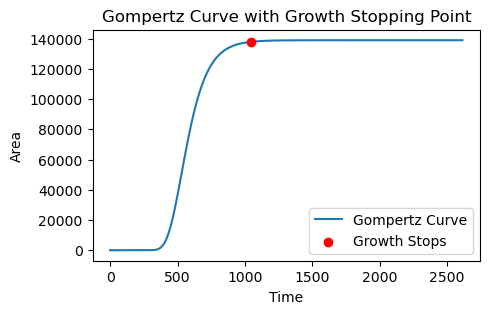

The colony stops growing around time: 1046
51


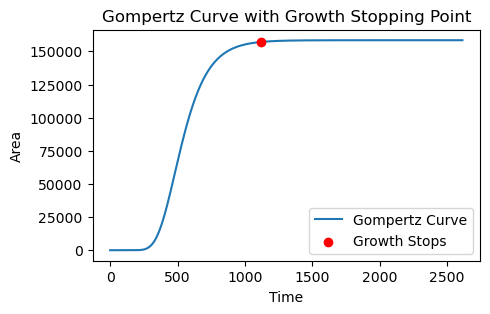

The colony stops growing around time: 1118
52


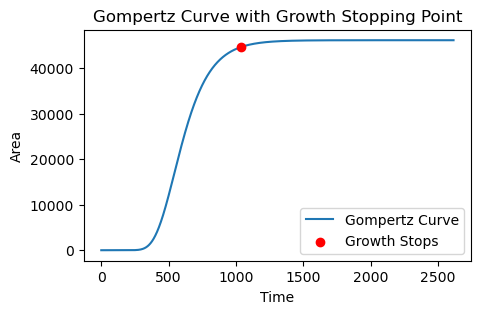

The colony stops growing around time: 1040
53


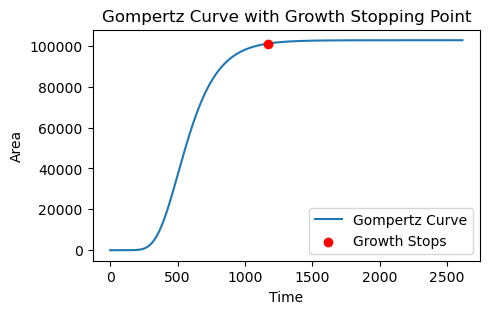

The colony stops growing around time: 1173
54


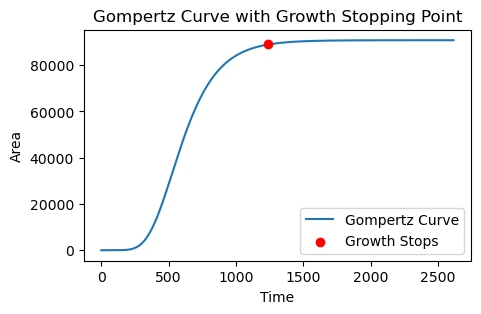

The colony stops growing around time: 1240
55


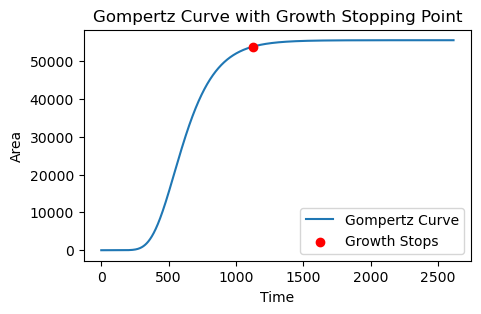

The colony stops growing around time: 1125
56


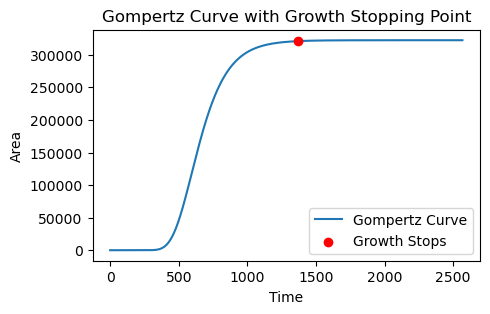

The colony stops growing around time: 1366
57


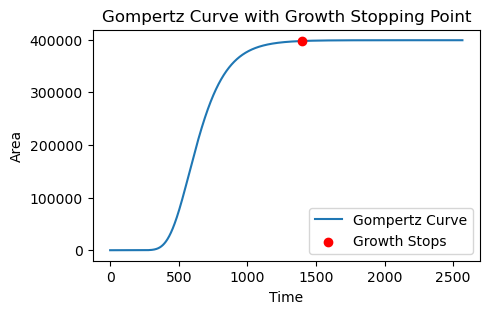

The colony stops growing around time: 1401
58


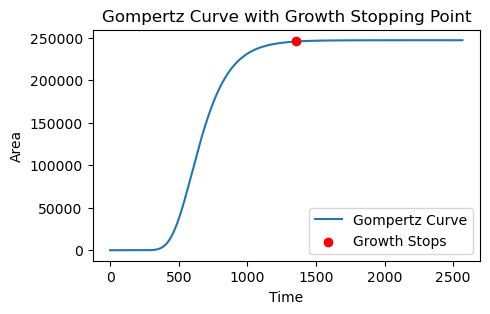

The colony stops growing around time: 1357
59


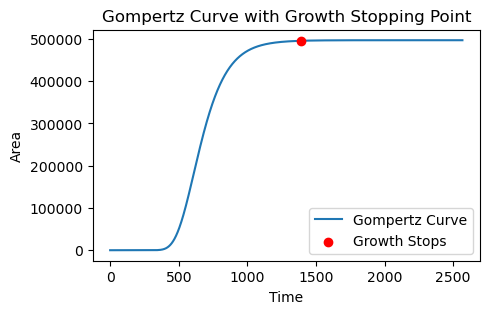

The colony stops growing around time: 1394
60


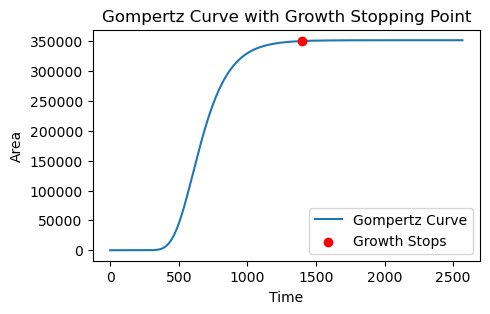

The colony stops growing around time: 1395
61


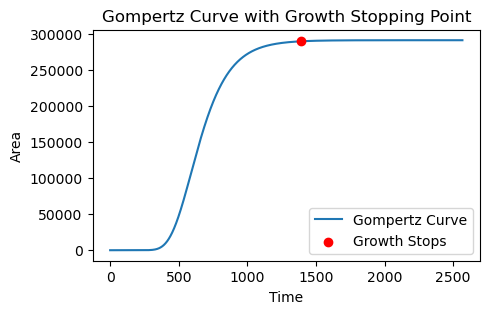

The colony stops growing around time: 1389
62


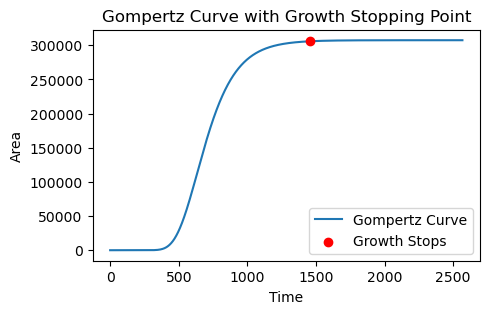

The colony stops growing around time: 1456
63


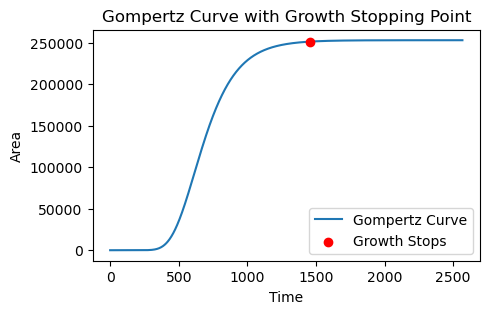

The colony stops growing around time: 1456
64


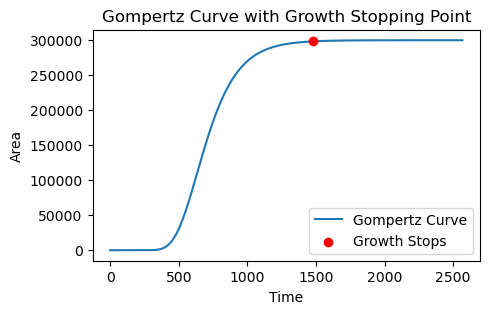

The colony stops growing around time: 1481
65


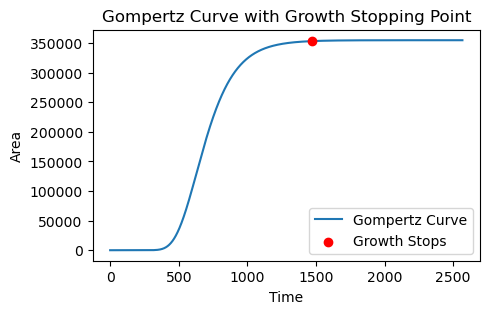

The colony stops growing around time: 1468
66


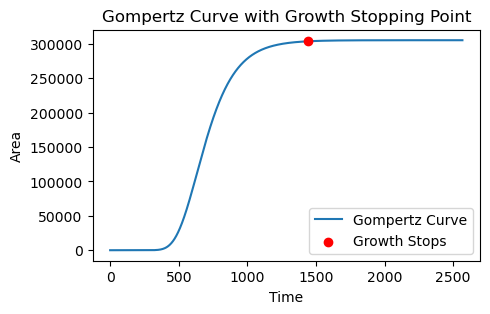

The colony stops growing around time: 1444
67


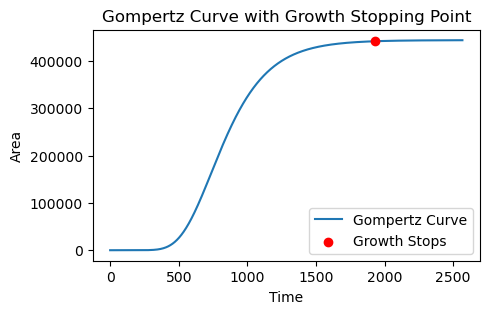

The colony stops growing around time: 1932
68


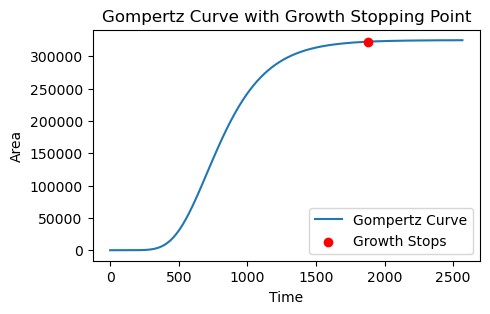

The colony stops growing around time: 1879
69


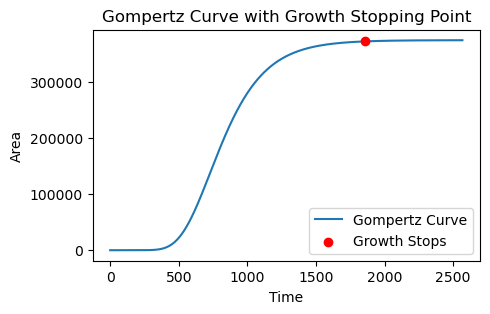

The colony stops growing around time: 1855
70


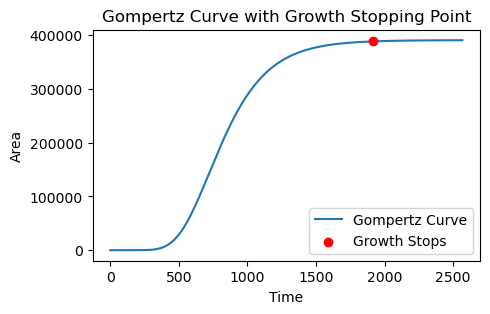

The colony stops growing around time: 1912
71


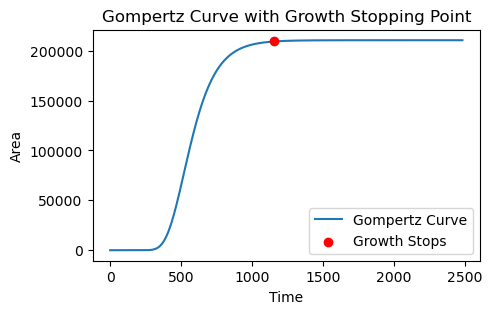

The colony stops growing around time: 1159
72


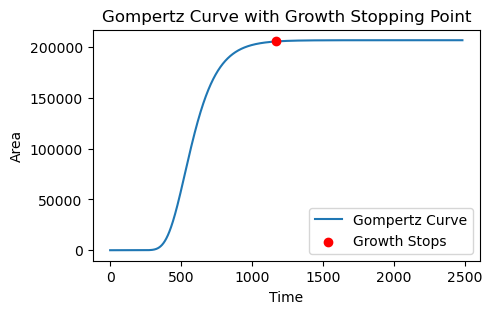

The colony stops growing around time: 1167
73


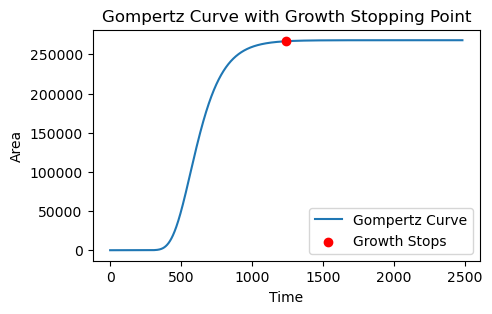

The colony stops growing around time: 1244
74


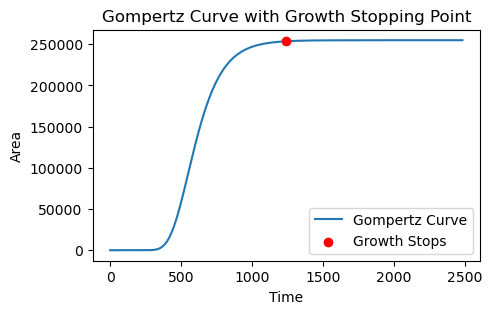

The colony stops growing around time: 1239
75


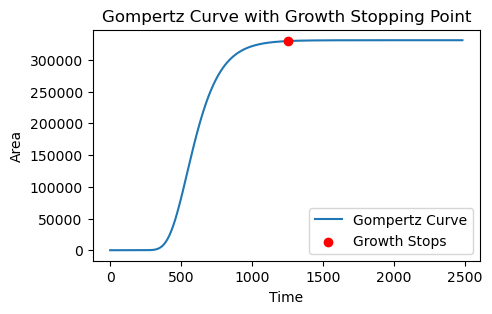

The colony stops growing around time: 1258
76


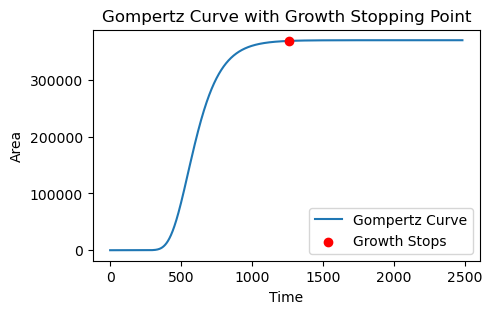

The colony stops growing around time: 1260
77


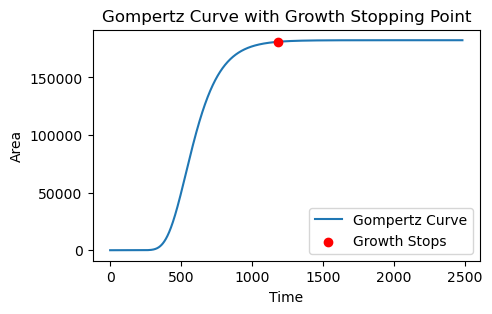

The colony stops growing around time: 1187
78


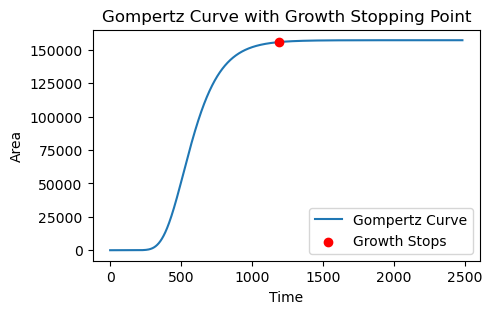

The colony stops growing around time: 1188
79


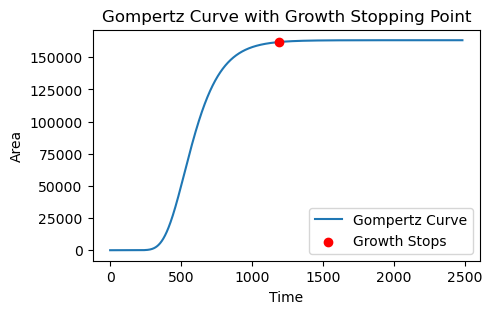

The colony stops growing around time: 1192
80


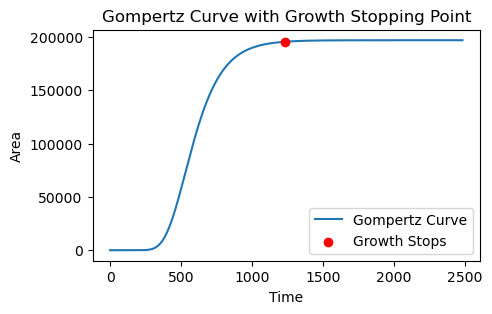

The colony stops growing around time: 1233
81


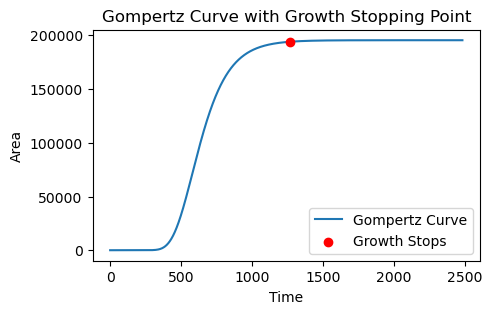

The colony stops growing around time: 1270
82


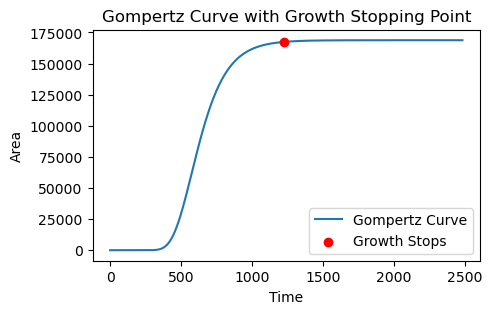

The colony stops growing around time: 1227
83


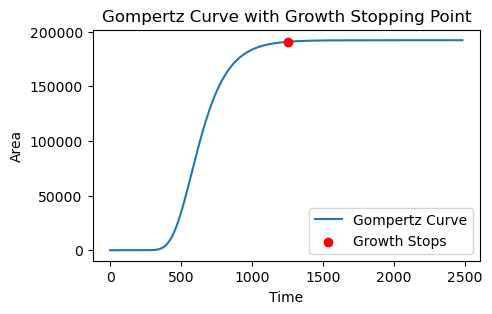

The colony stops growing around time: 1256
84


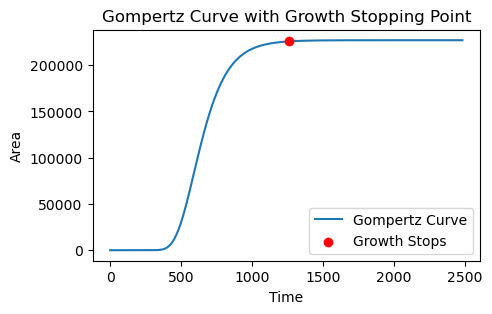

The colony stops growing around time: 1259
85


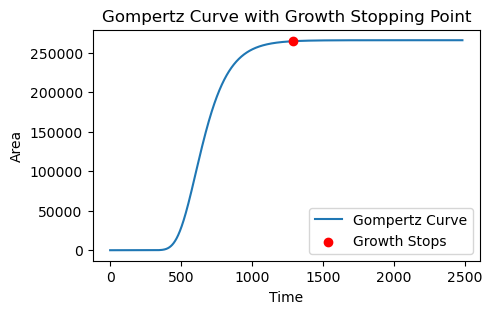

The colony stops growing around time: 1287
86


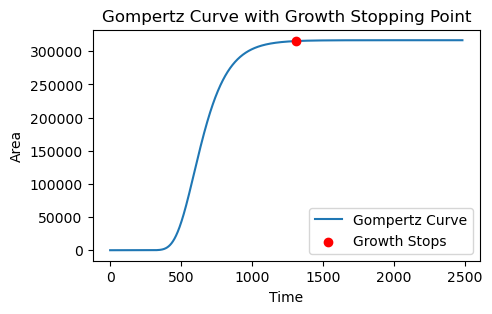

The colony stops growing around time: 1308
87


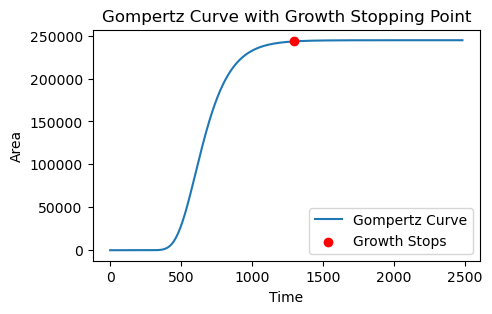

The colony stops growing around time: 1300
88


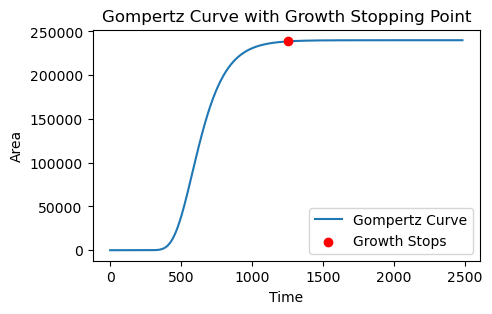

The colony stops growing around time: 1257
89


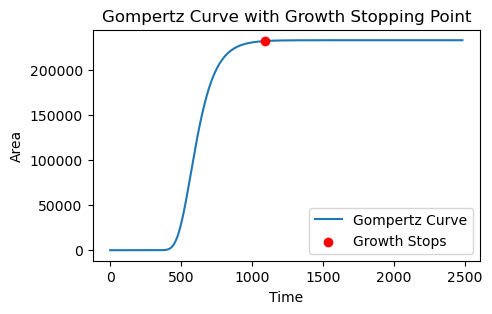

The colony stops growing around time: 1091
90


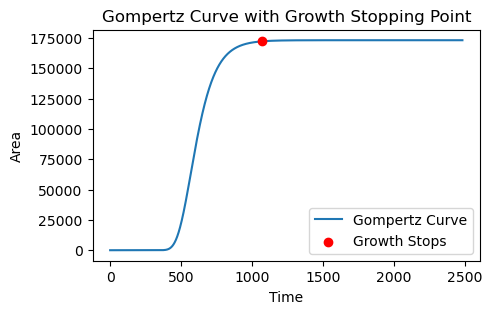

The colony stops growing around time: 1068
91


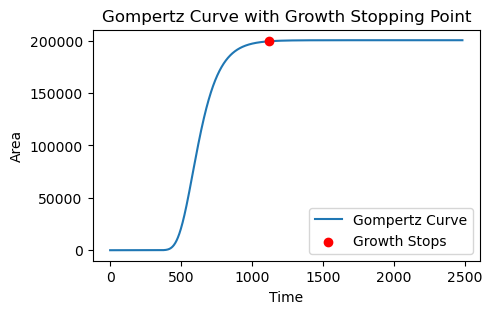

The colony stops growing around time: 1121
92


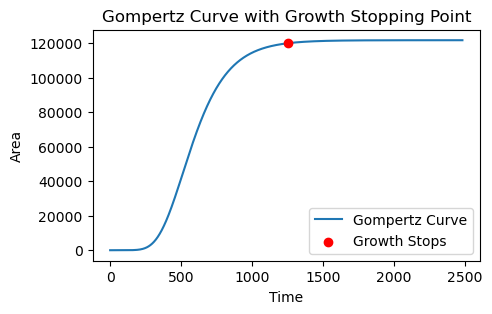

The colony stops growing around time: 1253
93


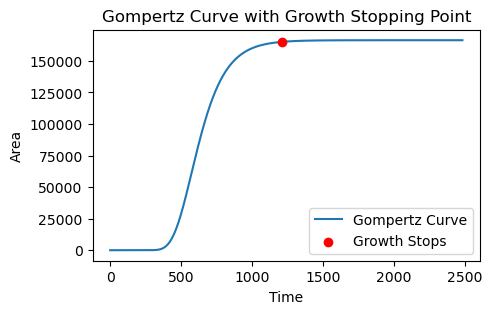

The colony stops growing around time: 1210
94


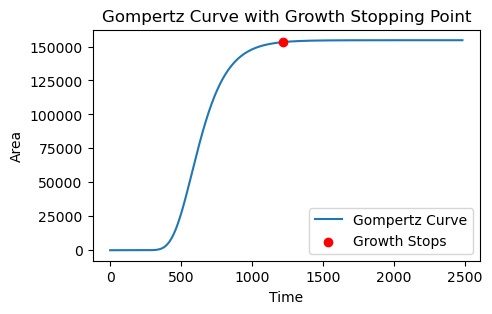

The colony stops growing around time: 1221
95


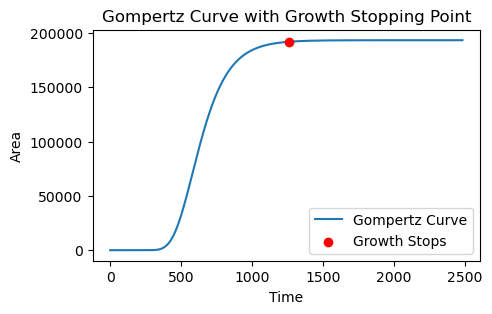

The colony stops growing around time: 1265
96


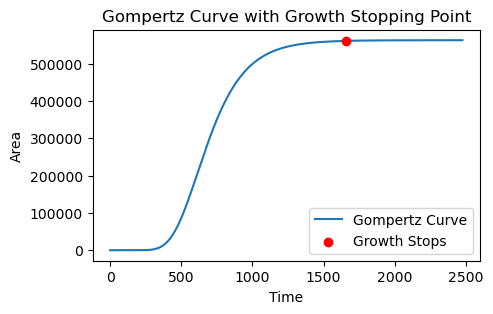

The colony stops growing around time: 1657
97


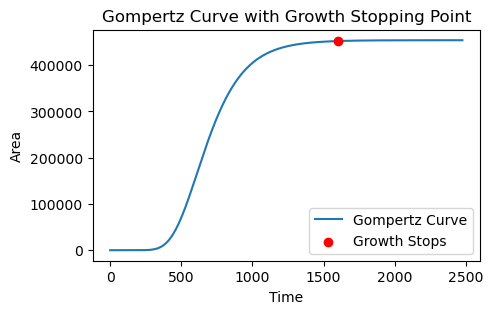

The colony stops growing around time: 1603
98


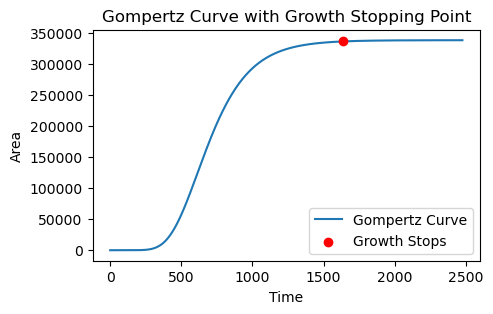

The colony stops growing around time: 1634
99


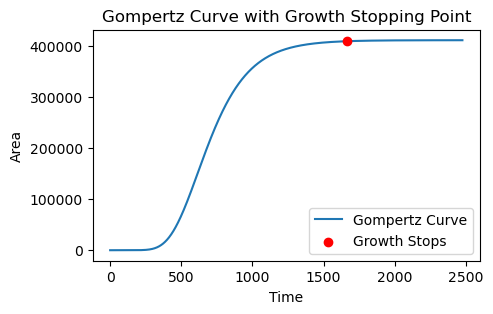

The colony stops growing around time: 1666
100


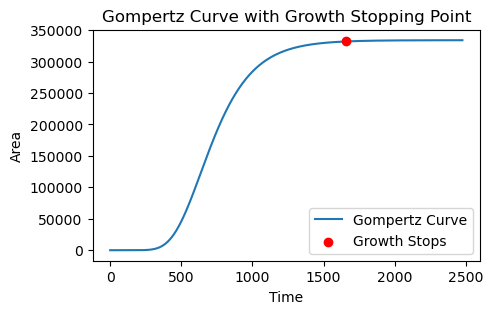

The colony stops growing around time: 1657
101


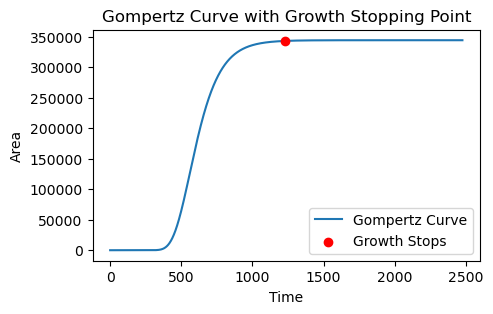

The colony stops growing around time: 1228
102


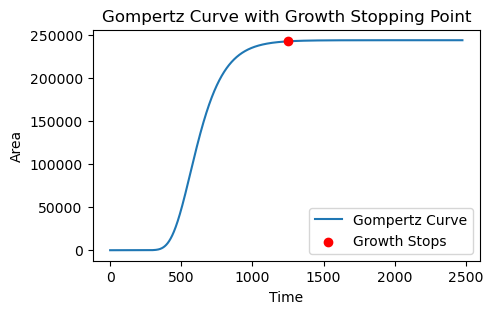

The colony stops growing around time: 1248
103


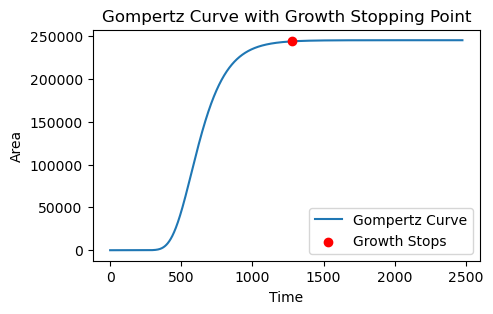

The colony stops growing around time: 1276
104


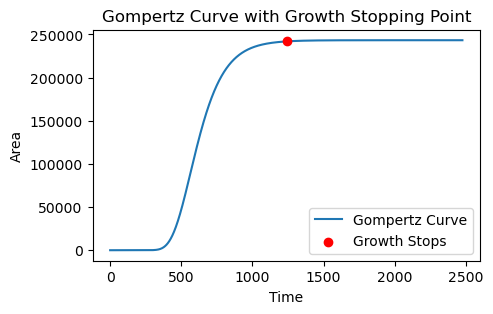

The colony stops growing around time: 1246
105


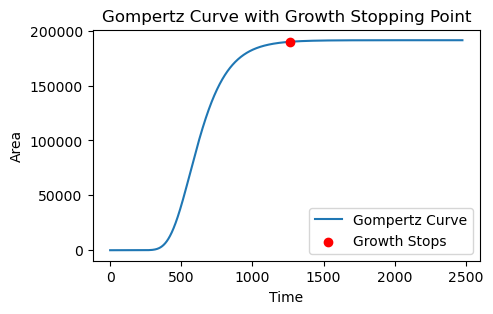

The colony stops growing around time: 1262
106


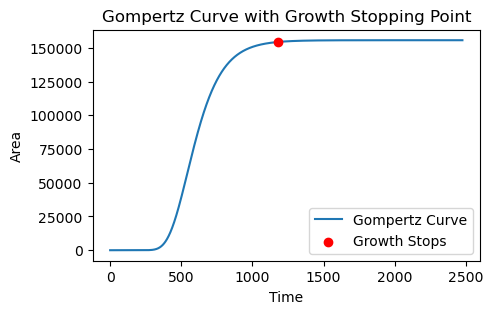

The colony stops growing around time: 1176
107


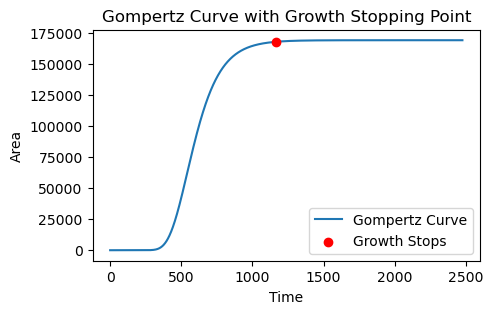

The colony stops growing around time: 1164
108


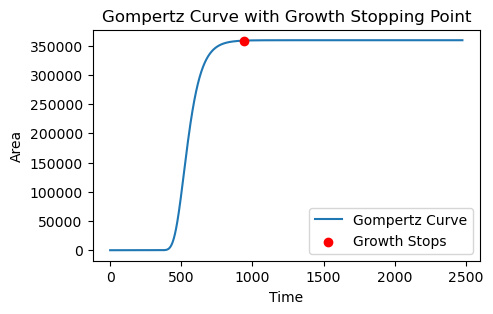

The colony stops growing around time: 941
109


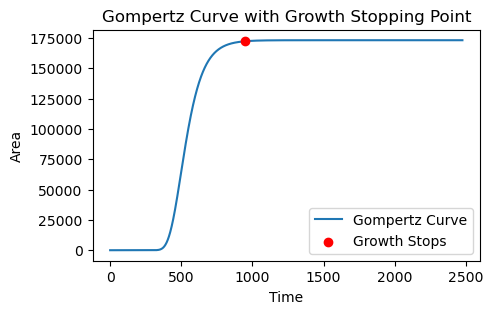

The colony stops growing around time: 949
110


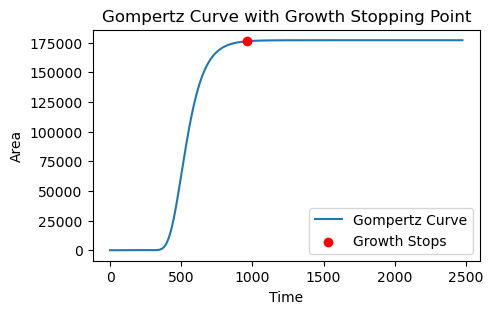

The colony stops growing around time: 962
111


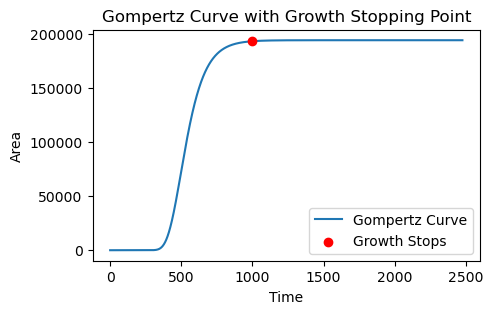

The colony stops growing around time: 999
112


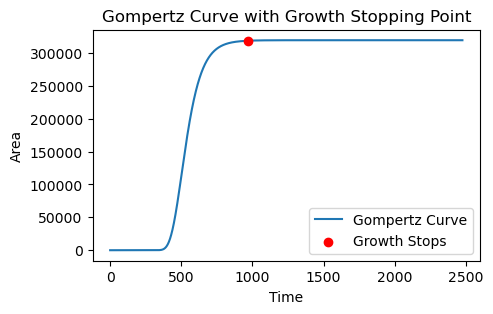

The colony stops growing around time: 969
113


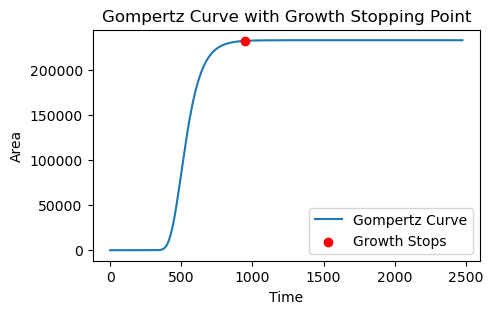

The colony stops growing around time: 944
114


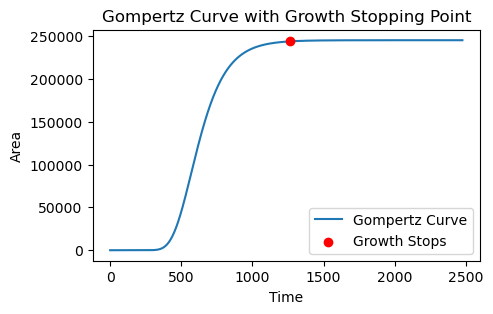

The colony stops growing around time: 1265
115


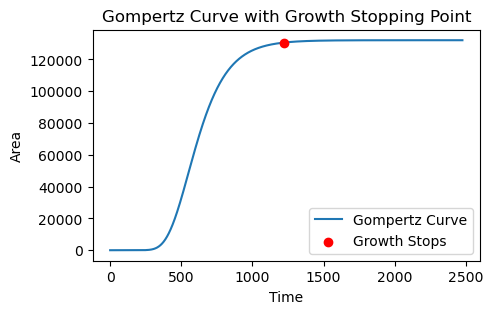

The colony stops growing around time: 1219
116


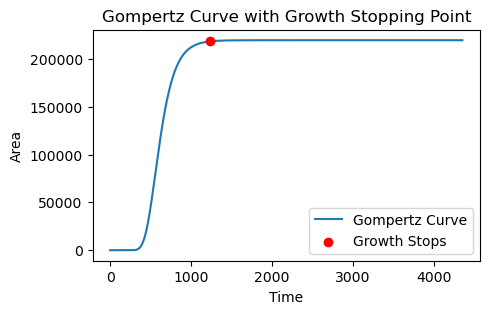

The colony stops growing around time: 1228
117


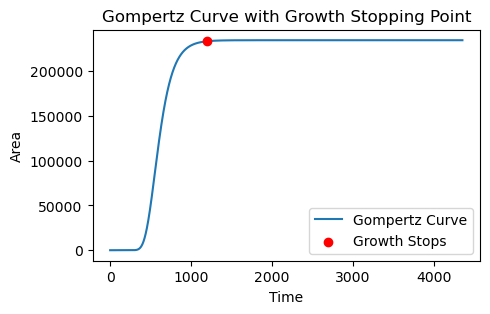

The colony stops growing around time: 1191
118


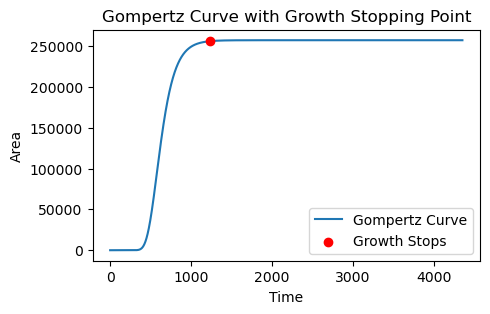

The colony stops growing around time: 1230
119


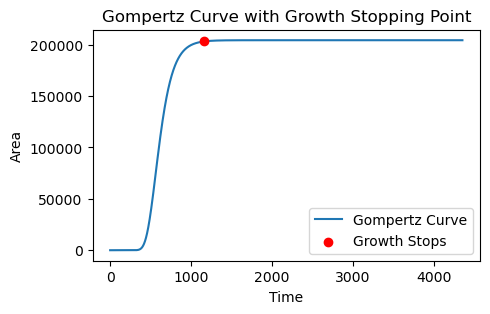

The colony stops growing around time: 1163
120


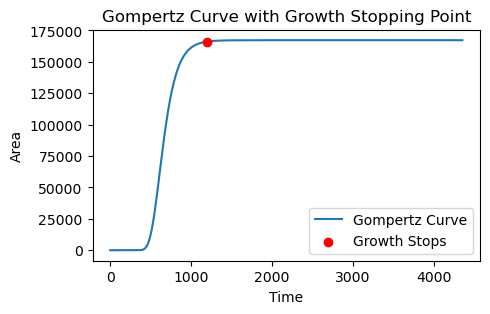

The colony stops growing around time: 1191
121


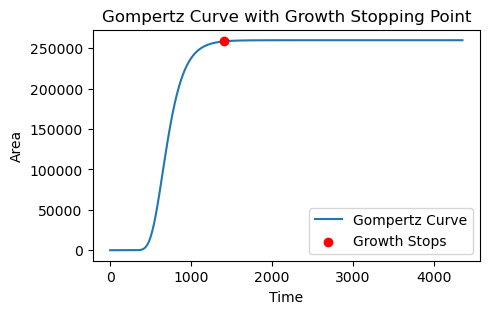

The colony stops growing around time: 1404
122


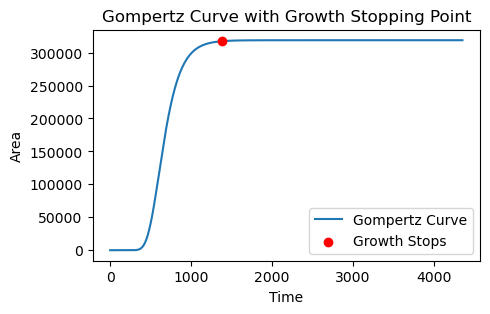

The colony stops growing around time: 1385
123


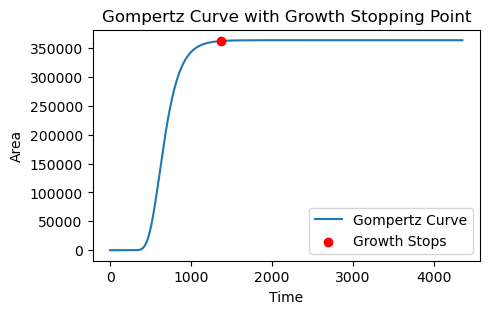

The colony stops growing around time: 1373
124


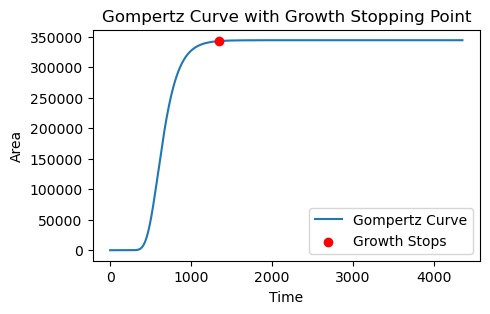

The colony stops growing around time: 1350
125


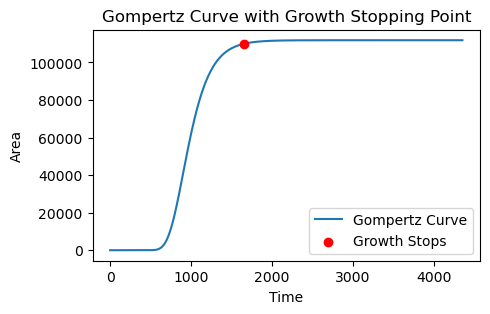

The colony stops growing around time: 1657
126


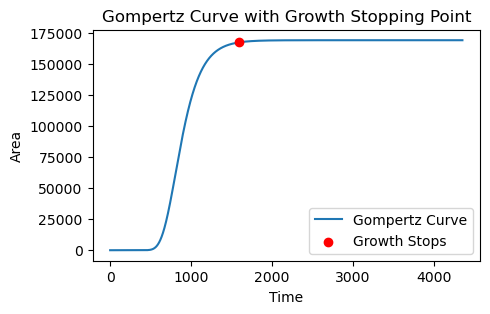

The colony stops growing around time: 1595
127


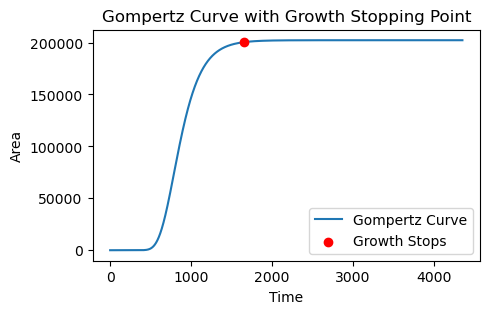

The colony stops growing around time: 1655
128


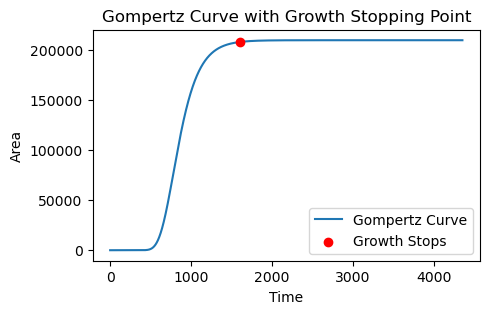

The colony stops growing around time: 1606
129


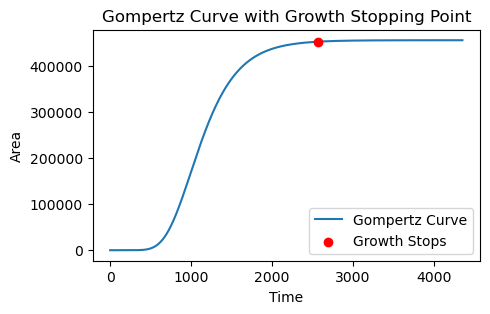

The colony stops growing around time: 2568
130


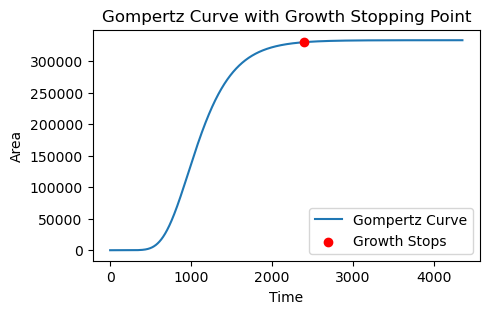

The colony stops growing around time: 2399
131


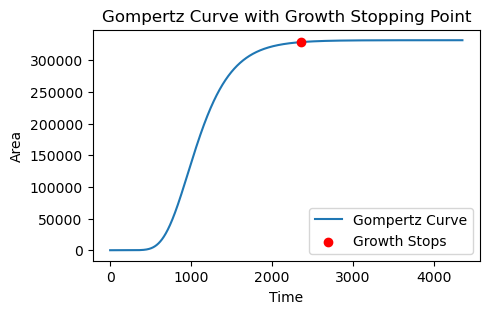

The colony stops growing around time: 2358
132


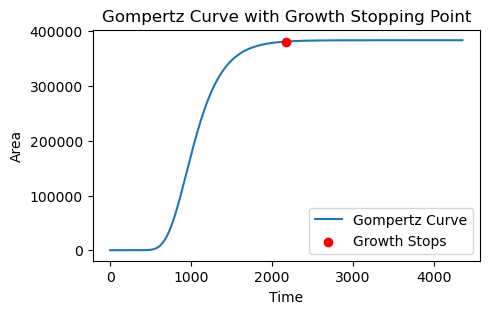

The colony stops growing around time: 2172
133


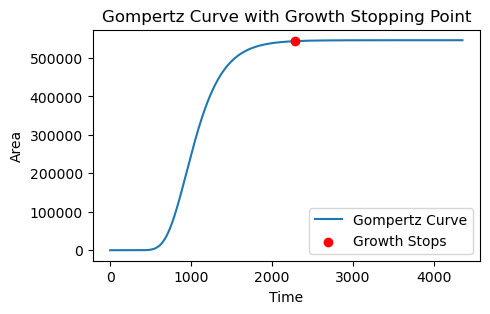

The colony stops growing around time: 2278
134


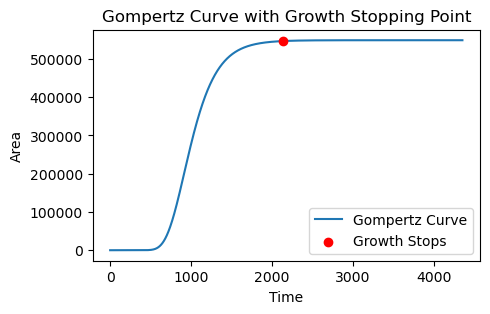

The colony stops growing around time: 2134
135


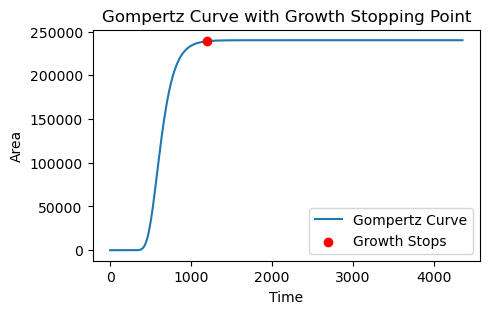

The colony stops growing around time: 1197
136


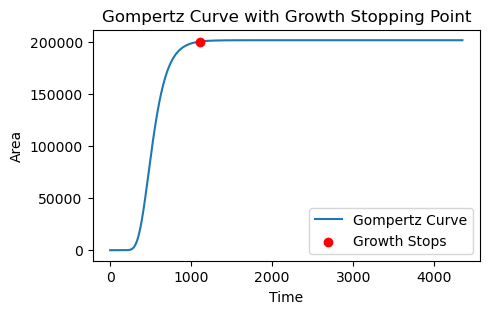

The colony stops growing around time: 1113
137


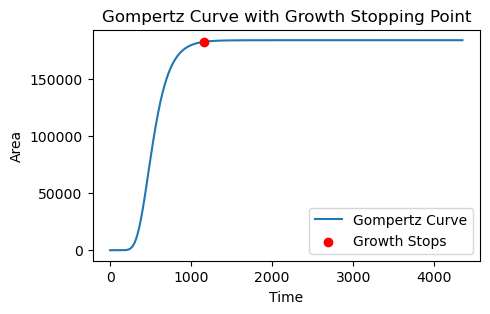

The colony stops growing around time: 1158
138


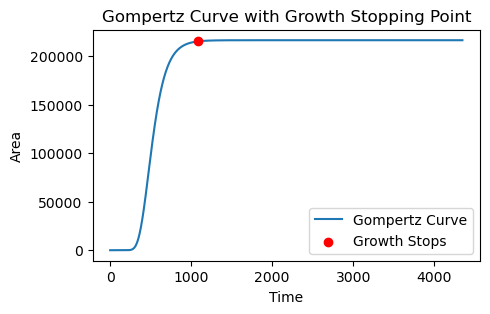

The colony stops growing around time: 1087
139


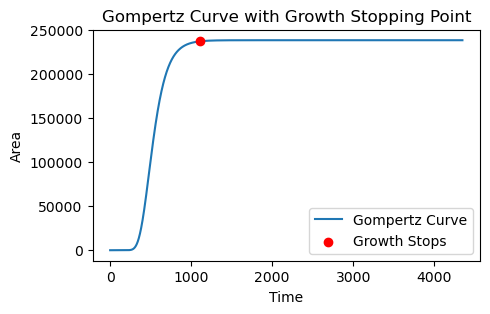

The colony stops growing around time: 1115
140


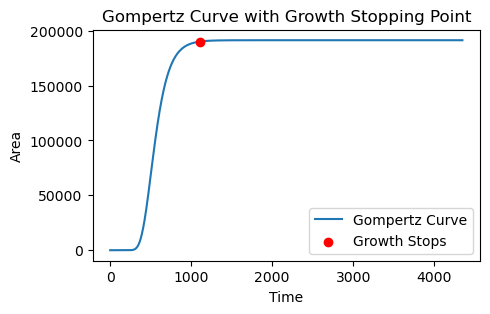

The colony stops growing around time: 1111
141


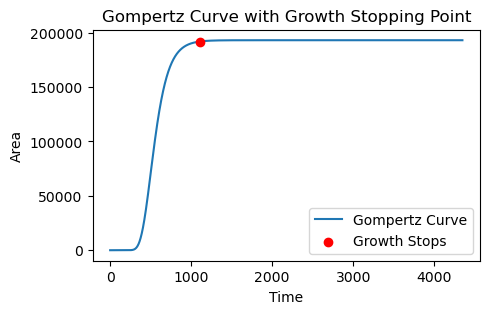

The colony stops growing around time: 1107
142


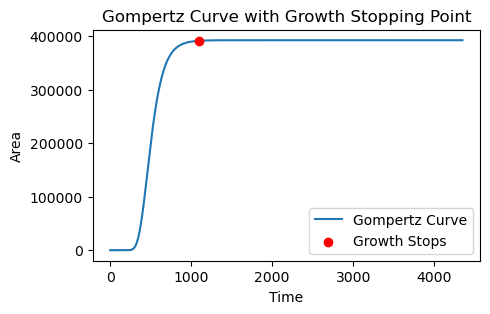

The colony stops growing around time: 1097
143


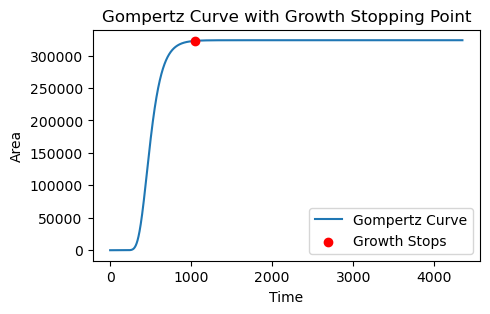

The colony stops growing around time: 1045
144


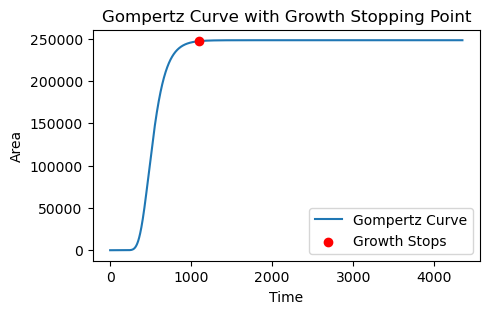

The colony stops growing around time: 1095
145


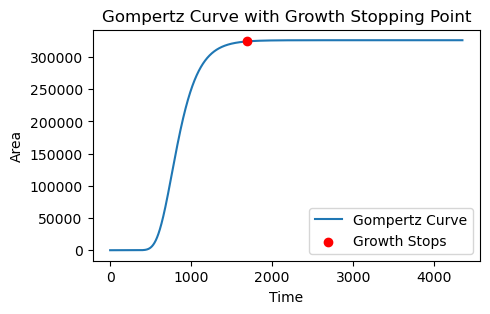

The colony stops growing around time: 1695
146


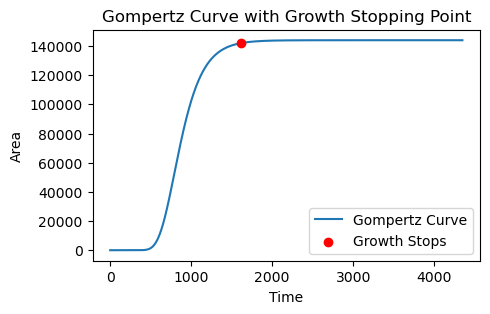

The colony stops growing around time: 1621
147


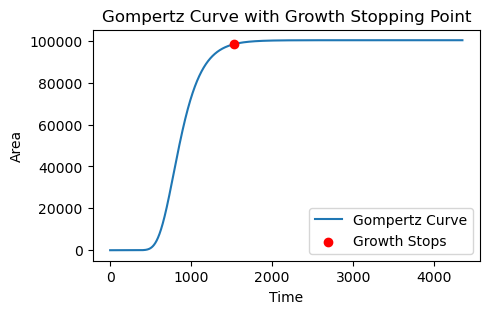

The colony stops growing around time: 1529
148


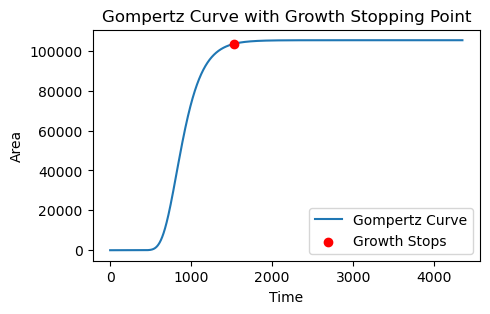

The colony stops growing around time: 1534
149


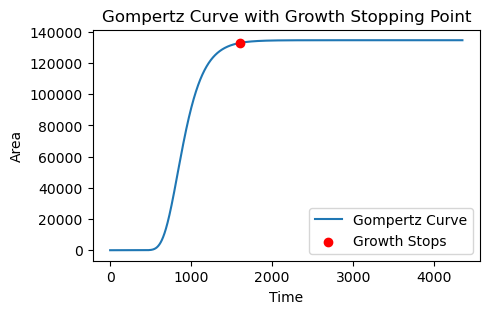

The colony stops growing around time: 1598
150


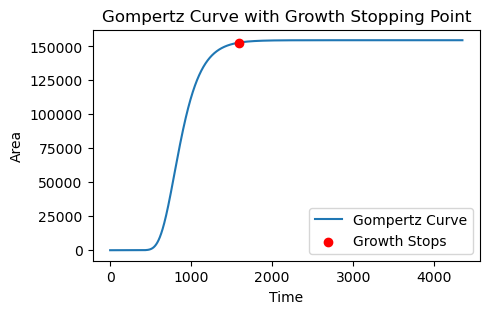

The colony stops growing around time: 1588
151


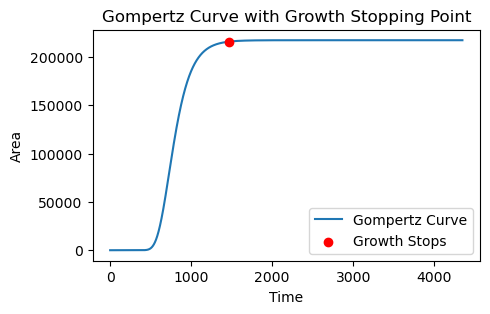

The colony stops growing around time: 1465
152


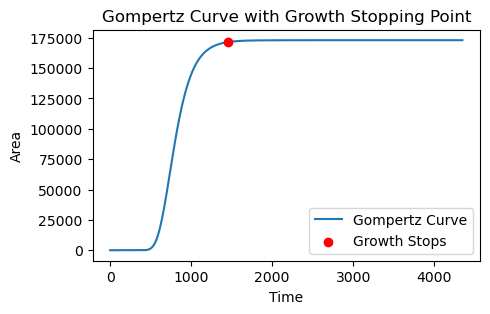

The colony stops growing around time: 1456
153


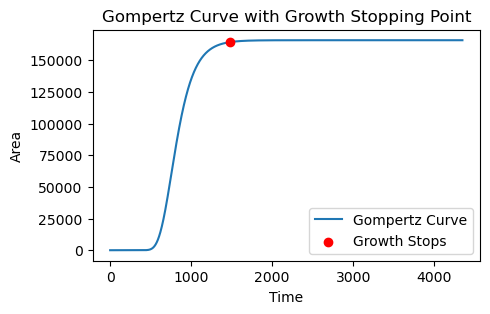

The colony stops growing around time: 1475
154


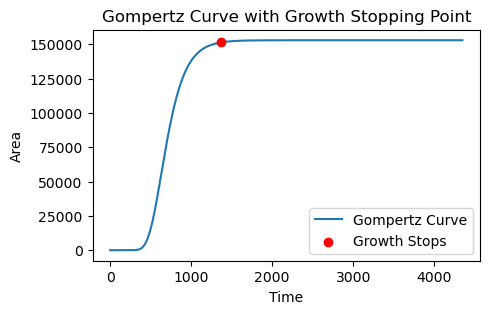

The colony stops growing around time: 1368
155


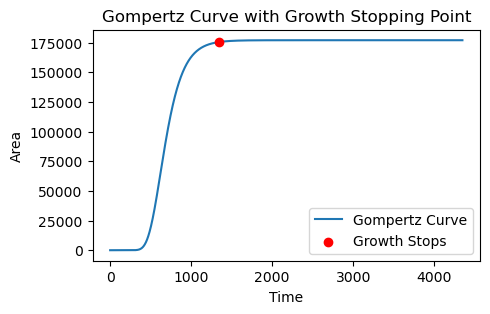

The colony stops growing around time: 1345
156


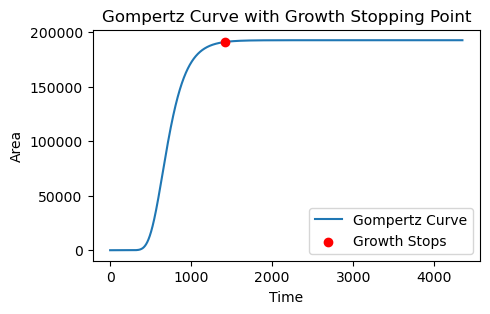

The colony stops growing around time: 1417
157


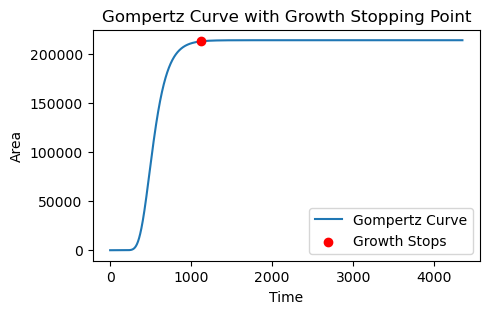

The colony stops growing around time: 1116
158


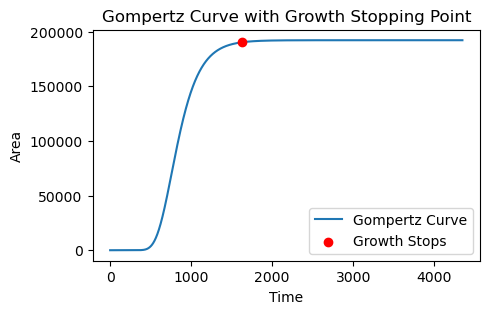

The colony stops growing around time: 1628
159


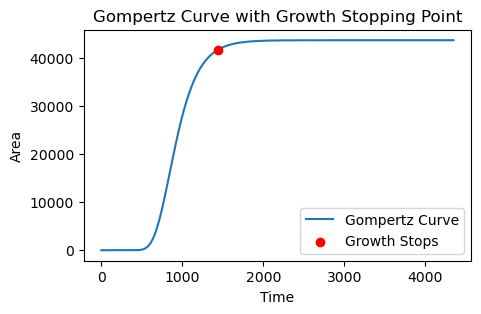

The colony stops growing around time: 1440


In [169]:
for i in df.index.values:
    print(i)
    params = [df.loc[i,'exp_A_gompertz_um'],df.loc[i,'exp_mu_gompertz_um'],df.loc[i,'exp_l_gompertz_um']]
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60 ## time in minutes
    tf = int(incub_time_n + df.loc[i, 'exp length']*10)
    time = np.arange(0, tf)
    gomp = gompertz(time, *params)  # Gompertz curve based on fitted parameters
    
    # First derivative of the Gompertz curve (growth rate)
    diff = savgol_filter(gomp, 21, 1, deriv=1)
    
    # Find the index of the maximum growth rate (where diff is maximum)
    max_growth_idx = np.argmax(diff)
    
    # Define a threshold for when the growth rate is considered to have stopped
    threshold = 10  # Example threshold, can be adjusted based on data
    
    # Find the index where growth rate drops below the threshold after the period of max growth
    stopping_idx = np.where((diff[max_growth_idx:] < threshold))[0]
    
    # Add max_growth_idx to the stopping_idx to get the correct position in the original array
    if stopping_idx.size > 0:
        stopping_idx = stopping_idx[0] + max_growth_idx  # First point after max growth where diff < threshold
    else:
        stopping_idx = len(time) - 1  # If no point is found, set it to the end of the time range
    
    # Get the stopping time
    stopping_time = time[stopping_idx]
    df.at[i, 'exp_gomp_growth_stops_10'] = stopping_time
    # Plot the original Gompertz curve and the point where the growth stops
    plt.figure(figsize=(5,3))
    
    # Plot the Gompertz curve
    plt.plot(time, gomp, label='Gompertz Curve')
    
    # Mark the stopping point
    plt.scatter(stopping_time, gomp[stopping_idx], color='red', zorder=5, label='Growth Stops')
    
    # Label and title
    plt.xlabel('Time')
    plt.ylabel('Area')
    plt.title('Gompertz Curve with Growth Stopping Point')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Output the result
    print(f"The colony stops growing around time: {stopping_time}")


In [170]:
#df.to_excel('../data_processed.xlsx', index=False)

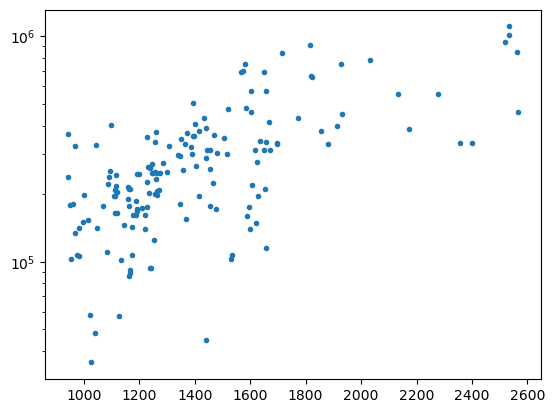

In [206]:
plt.yscale('log')
#plt.xlim([0,2700])
plt.plot(df['exp_gomp_growth_stops_10'],df['area_max_um'],'.')

In [208]:
positions_with_totals.head()

Date   Machine  Position  Strain            DNA Chemical  Pad  \
0 2023-11-15  Ti scope         0  MC4100  pLPT20&pLPT41        -    1   
1 2023-11-15  Ti scope         1  MC4100  pLPT20&pLPT41        -    1   
2 2023-11-15  Ti scope         3  MC4100  pLPT20&pLPT41        -    1   
3 2023-11-15  Ti scope         6  MC4100  pLPT20&pLPT41        -    1   
4 2023-11-15  Ti scope         7  MC4100  pLPT20&pLPT41        -    1   

  Dilution   t_incub      t_im  ...  t_m_logistic_px t_m_logistic_um  \
0  10^(-5)  09:25:00  14:41:00  ...       225.219582      222.192596   
1  10^(-5)  09:25:00  14:41:00  ...       216.254727      214.616296   
2  10^(-5)  09:25:00  14:41:00  ...       209.428395      207.882467   
3  10^(-5)  09:25:00  14:41:00  ...       199.904423      198.436991   
4  10^(-5)  09:25:00  14:41:00  ...       211.573719      208.804174   

       r0_um                             exp_gompertz_params_um  \
0  25.726989  {"A": 103786.40805606885, "mu_m": 343.23542055...   
1  37.567485  {"A": 148648.89711510084, "mu_m": 486.68795192...   
2  50.002925  {"A": 138470.38679296238, "mu_m": 463.74374579...   
3  23.368757  {"A": 100919.60666645512, "mu_m": 319.21784622...   
4  35.216651  {"A": 131433.34432578104, "mu_m": 451.35653828...   

                              exp_logistic_params_um  exp_A_gompertz_um  \
0  {"A": 103366.57837067322, "mu_m": 332.93634006...      103786.408056   
1  {"A": 148057.68875721024, "mu_m": 469.79915164...      148648.897115   
2  {"A": 137951.62607133528, "mu_m": 444.93982071...      138470.386793   
3  {"A": 100554.69020091348, "mu_m": 301.18127957...      100919.606666   
4  {"A": 130968.07500264472, "mu_m": 432.72130505...      131433.344326   

   exp_mu_gompertz_um  exp_l_gompertz_um  exp_gomp_growth_stops_10  \
0          343.235421         366.413048                       982   
1          486.687952         354.501293                      1015   
2          463.743746         343.273677                       984   
3          319.217846         320.089559                       955   
4          451.356538         345.419715                       968   

   total_colonies  
0            19.0  
1            19.0  
2            19.0  
3            19.0  
4            19.0  

[5 rows x 52 columns]

Text(0.5, 0, 'N')

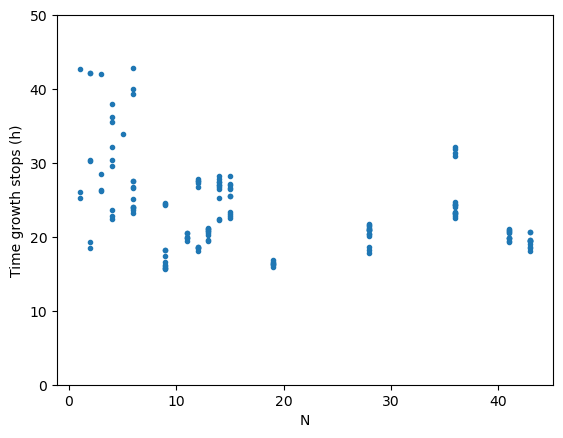

In [215]:
plt.plot(positions_with_totals['total_colonies'],positions_with_totals['exp_gomp_growth_stops_10']/60,'.')
plt.ylabel('Time growth stops (h)')
plt.ylim([0,50])
plt.xlabel('N')